In [2]:
import os
import math
import shap
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

from imblearn.over_sampling import BorderlineSMOTE
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings("ignore")


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
# Defining some useful variables

# Set the project folder
PRJ_FOLDER = '.'
# Set the folder the full dataset is located
DATA_FOLDER = os.path.join(PRJ_FOLDER, 'data')
# Set the name of the file that holds the full dataset
FULL_DATASET_NAME = 'full.csv'
# Set "No Audio" dataset
NO_AUDIO_DATASET_NAME = 'no_audio_corrected.csv'
# Set the name of the file that holds the angraphic information
LABELS_NAME = 'labels.csv'

TOP_K = 16

# Load the labels only once, in order to reuse them
LABELS = pd.read_csv(os.path.join(DATA_FOLDER, LABELS_NAME))

# SMOTE Upsampler
SMOTE = BorderlineSMOTE()


print(f'Folder where the entire project is located: {PRJ_FOLDER}')
print(f'Folder where the full dataset is saved: {DATA_FOLDER}')
print(f'Name of the full dataset: {FULL_DATASET_NAME}')
print(f'Name of the anagraphic dataset: {LABELS_NAME}')

Folder where the entire project is located: .
Folder where the full dataset is saved: .\data
Name of the full dataset: full.csv
Name of the anagraphic dataset: labels.csv


In [4]:
# Let's define a simple function that loads a single dataset

def load_raw_data(csv_path: str, feat_to_predict: str):
    # Load the entire csv file
    data = pd.read_csv(csv_path)

    # Join labels and data so that truth values are aligned with original data
    lbls = LABELS[['id', feat_to_predict]]
    temp = data.merge(lbls, on='id', how='left')
    temp = temp.dropna()
    # Extract only the ground truths
    labels = pd.DataFrame(temp[feat_to_predict], columns=[feat_to_predict])
    data = temp.drop(feat_to_predict, axis=1)
    data = data.set_index('id')
    data = pd.DataFrame(StandardScaler().fit_transform(data), columns=data.columns, index=data.index)

    return data, labels

In [5]:
def print_feats(feats):
    cur, idx = [], 0
    for feat in feats:
        cur.append(str(feat))
        idx += 1
        if (idx % 5) == 0:
            print(', '.join(cur) + ',')
            cur = []
    if len(cur) > 0:
        print(', '.join(cur))

In [6]:
def plot_best_feat(feats, scores, yerr=None, title: str = '', dimensions=(10,8)):
    plt.rcParams["figure.figsize"] = dimensions

    feats, scores = list(reversed(feats)), list(reversed(scores))

    if yerr:
        plt.barh(feats, scores, yerr=yerr, capsize=6)
    else:
        plt.barh(feats, scores)
    plt.title(title)
    plt.xlabel('Score')
    plt.show()
    print_feats(feats[::-1])
    return feats[::-1]

In [7]:
def plot_compounded(folds, title, dimensions=(10, 12)):
    plt.rcParams["figure.figsize"] = dimensions
    
    count = {}
    for feats, _ in folds:
        for feat in feats:
            if feat not in count:
                count[feat] = 0
            count[feat] += 1
    comp = sorted(list(count.items()), key=(lambda x: x[1]), reverse=True)
    feats, freqs = zip(*comp[:30])
    feats, freqs = list(reversed(list(feats))), list(reversed(list(freqs)))
    
    plt.barh(feats, freqs)
    plt.title(title)
    plt.xlabel('Frequency')
    plt.show()
    print_feats(feats[::-1])
    return feats[::-1]


# ML Approach

In [8]:
def ml_analysis(feat_to_predict, audio=True):
    PATH = os.path.join(DATA_FOLDER, FULL_DATASET_NAME if audio else NO_AUDIO_DATASET_NAME)

    X, y = load_raw_data(PATH, feat_to_predict)
    results = []
    for _ in range(1000):
        X_train, __, y_train, __ = train_test_split(X, y, test_size=0.2, stratify=y)
        X_train, y_train = SMOTE.fit_resample(X_train, y_train)
        
        sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
        sel.fit(X_train, y_train)

        support = sel.get_support()
        selected_feat = X.columns[support].tolist()
        selected_importances = sel.estimator_.feature_importances_.ravel()
        
        final_sorted = sorted(list(zip(selected_feat, selected_importances)), key=(lambda x: x[1]), reverse=True)
        feats, importances = zip(*(final_sorted[:TOP_K]))
        results.append((feats, importances))

    return plot_compounded(results, feat_to_predict)


### Full Data

In [9]:
#ml_analysis('MOCA_impairment')
#ml_analysis('tTau_AB42Positivity')
#ml_analysis('AB42_AB40Positivity')
pass

### No Audio

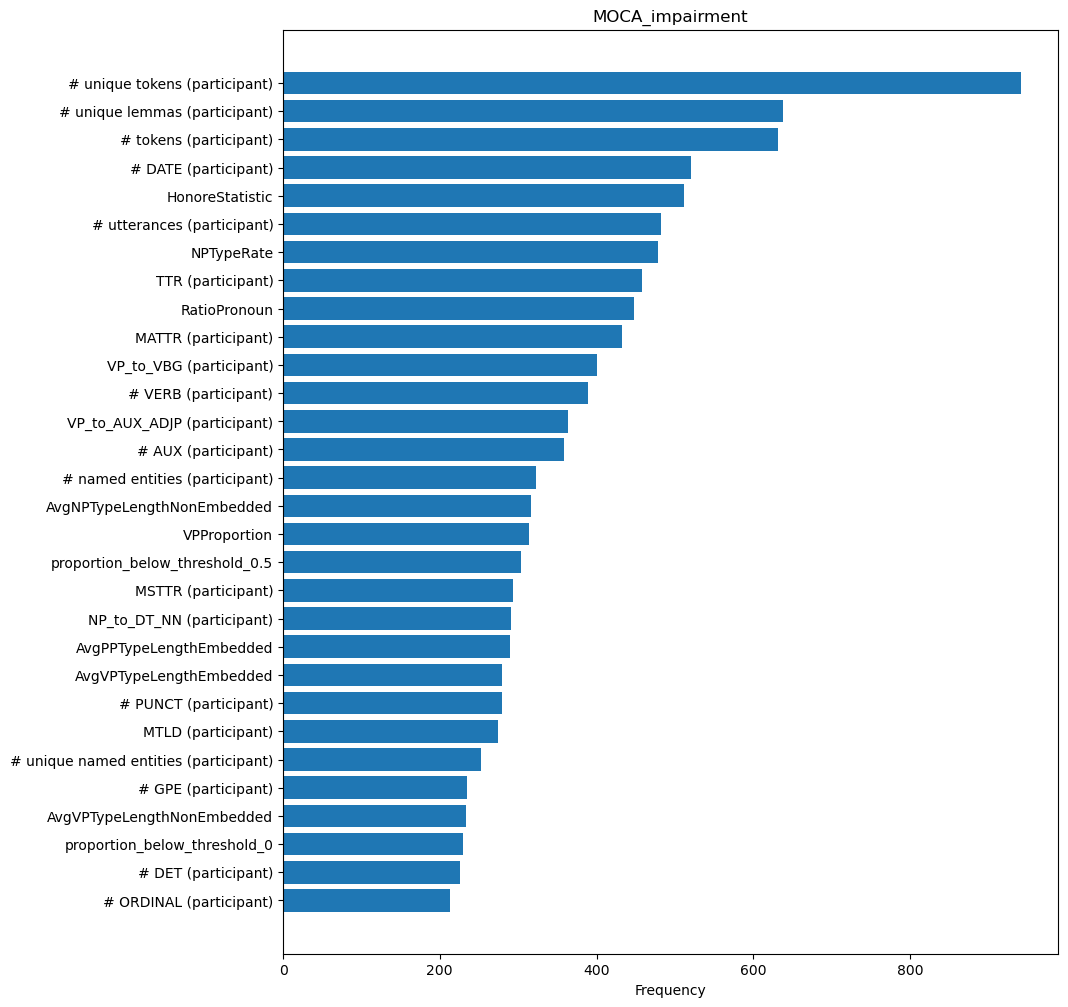

# unique tokens (participant), # unique lemmas (participant), # tokens (participant), # DATE (participant), HonoreStatistic,
# utterances (participant), NPTypeRate, TTR (participant), RatioPronoun, MATTR (participant),
VP_to_VBG (participant), # VERB (participant), VP_to_AUX_ADJP (participant), # AUX (participant), # named entities (participant),
AvgNPTypeLengthNonEmbedded, VPProportion, proportion_below_threshold_0.5, MSTTR (participant), NP_to_DT_NN (participant),
AvgPPTypeLengthEmbedded, AvgVPTypeLengthEmbedded, # PUNCT (participant), MTLD (participant), # unique named entities (participant),
# GPE (participant), AvgVPTypeLengthNonEmbedded, proportion_below_threshold_0, # DET (participant), # ORDINAL (participant),


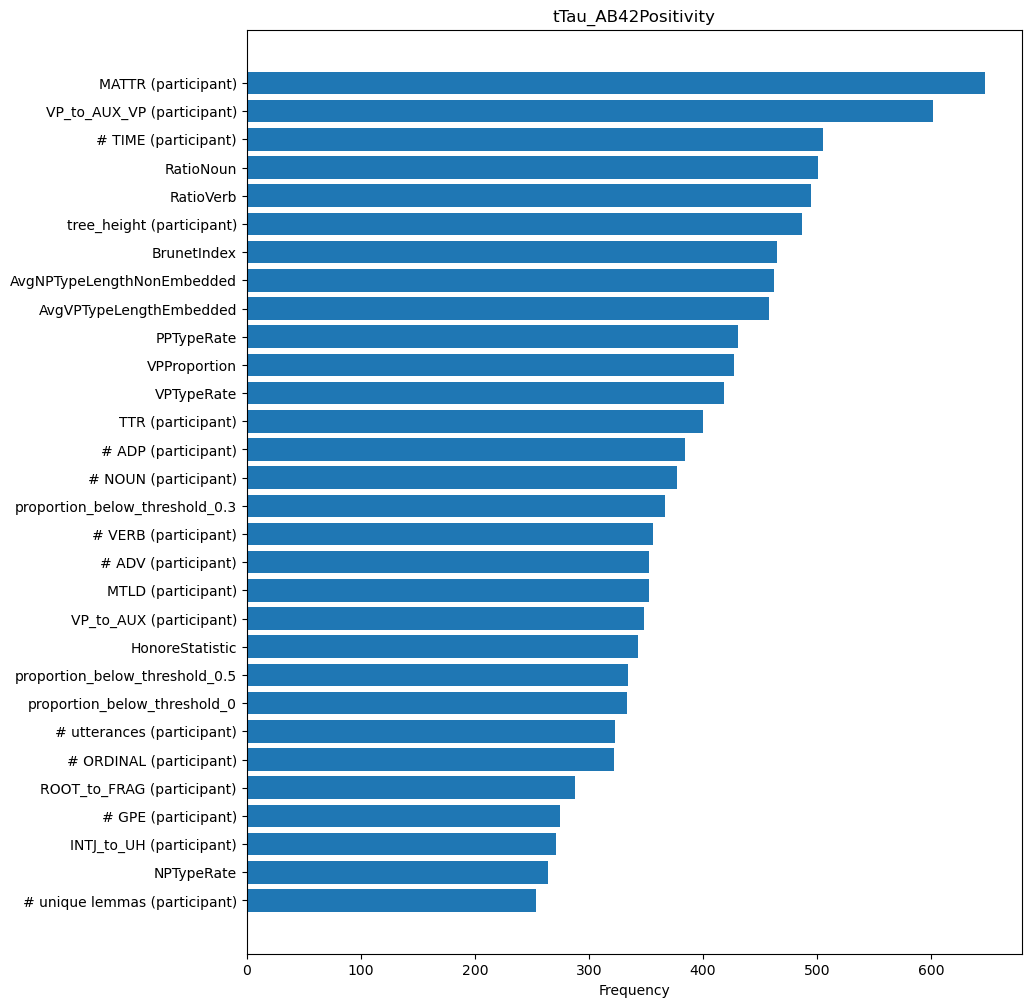

MATTR (participant), VP_to_AUX_VP (participant), # TIME (participant), RatioNoun, RatioVerb,
tree_height (participant), BrunetIndex, AvgNPTypeLengthNonEmbedded, AvgVPTypeLengthEmbedded, PPTypeRate,
VPProportion, VPTypeRate, TTR (participant), # ADP (participant), # NOUN (participant),
proportion_below_threshold_0.3, # VERB (participant), # ADV (participant), MTLD (participant), VP_to_AUX (participant),
HonoreStatistic, proportion_below_threshold_0.5, proportion_below_threshold_0, # utterances (participant), # ORDINAL (participant),
ROOT_to_FRAG (participant), # GPE (participant), INTJ_to_UH (participant), NPTypeRate, # unique lemmas (participant),


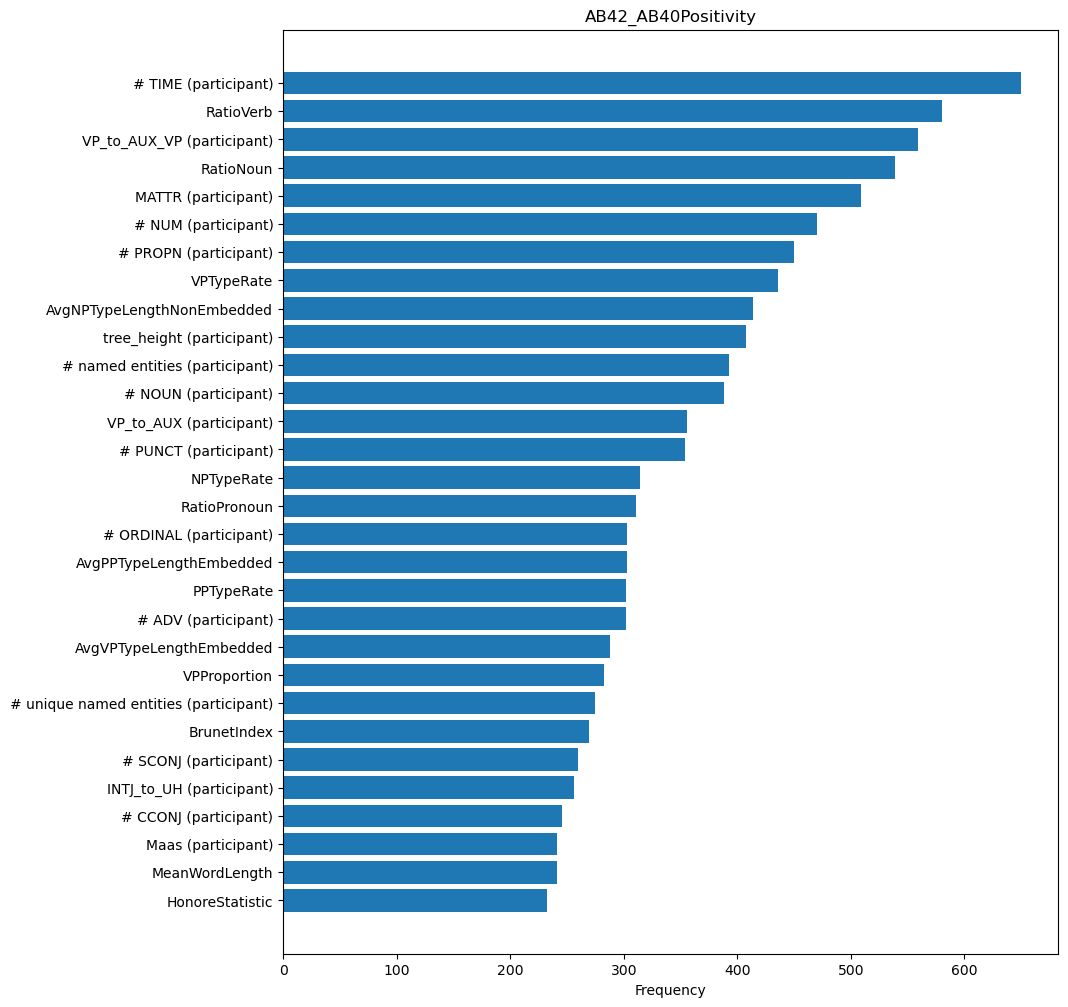

# TIME (participant), RatioVerb, VP_to_AUX_VP (participant), RatioNoun, MATTR (participant),
# NUM (participant), # PROPN (participant), VPTypeRate, AvgNPTypeLengthNonEmbedded, tree_height (participant),
# named entities (participant), # NOUN (participant), VP_to_AUX (participant), # PUNCT (participant), NPTypeRate,
RatioPronoun, # ORDINAL (participant), AvgPPTypeLengthEmbedded, PPTypeRate, # ADV (participant),
AvgVPTypeLengthEmbedded, VPProportion, # unique named entities (participant), BrunetIndex, # SCONJ (participant),
INTJ_to_UH (participant), # CCONJ (participant), Maas (participant), MeanWordLength, HonoreStatistic,


In [10]:
MOCA_ML_NO_AUDIO_COMPUTED_FEATURES = ml_analysis('MOCA_impairment', audio=False)
TTAU_ML_NO_AUDIO_COMPUTED_FEATURES = ml_analysis('tTau_AB42Positivity', audio=False)
AB42_ML_NO_AUDIO_COMPUTED_FEATURES = ml_analysis('AB42_AB40Positivity', audio=False)

# Statistical Approach

In [11]:
def get_topK(X, y, cols, score_func, k=32):
    # Create object that will rank features based on the score function
    select = SelectKBest(score_func=score_func)
    top_ks = []
    top_scores = []
    # Obtain the scores for all the features
    scores = list(select.fit(X, y).scores_)
    # Associate each score to the feature that is related to
    n_scores = list(zip(scores, [i for i in range(len(scores))]))
    # Sort the scores from highest to lowest
    n_scores.sort(key=lambda x: x[0], reverse=True)
    # Retrieve scores and features indexes
    scores, pos = zip(*n_scores)
    # Save top-k scores and their feature names
    top_scores.append(list(scores[:k]))
    top_ks.append(list(cols[list(pos)[:k]]))

    return top_ks, top_scores

## F_Cassif

In [12]:
def f_info(feat_to_predict: str, audio=True):
    PATH = os.path.join(DATA_FOLDER, FULL_DATASET_NAME if audio else NO_AUDIO_DATASET_NAME)
    # Load the dataset
    X_raw, y_raw = load_raw_data(PATH, feat_to_predict)
    # Get the column names (without the label)
    cols = X_raw.columns.to_numpy()
    X, y = X_raw.to_numpy(), y_raw.to_numpy().ravel()

    # F Function
    f_top_ks, f_top_scores = get_topK(X, y, cols, f_classif)
    f_top_ks, f_top_scores = f_top_ks[0], f_top_scores[0]
    mapped = list(filter(lambda x: not math.isnan(x[1]), list(zip(f_top_ks, f_top_scores))))
    f_top_ks, f_top_scores = zip(*sorted(mapped, key=(lambda x: x[1]), reverse=True))
    return plot_best_feat(f_top_ks, f_top_scores, title=f'F_Function Scores ({feat_to_predict} - {"Full" if audio else "No Audio"})')

### Full Data

In [13]:
#f_info('MOCA_impairment')
#f_info('tTau_AB42Positivity')
#f_info('AB42_AB40Positivity')
pass

### No Audio

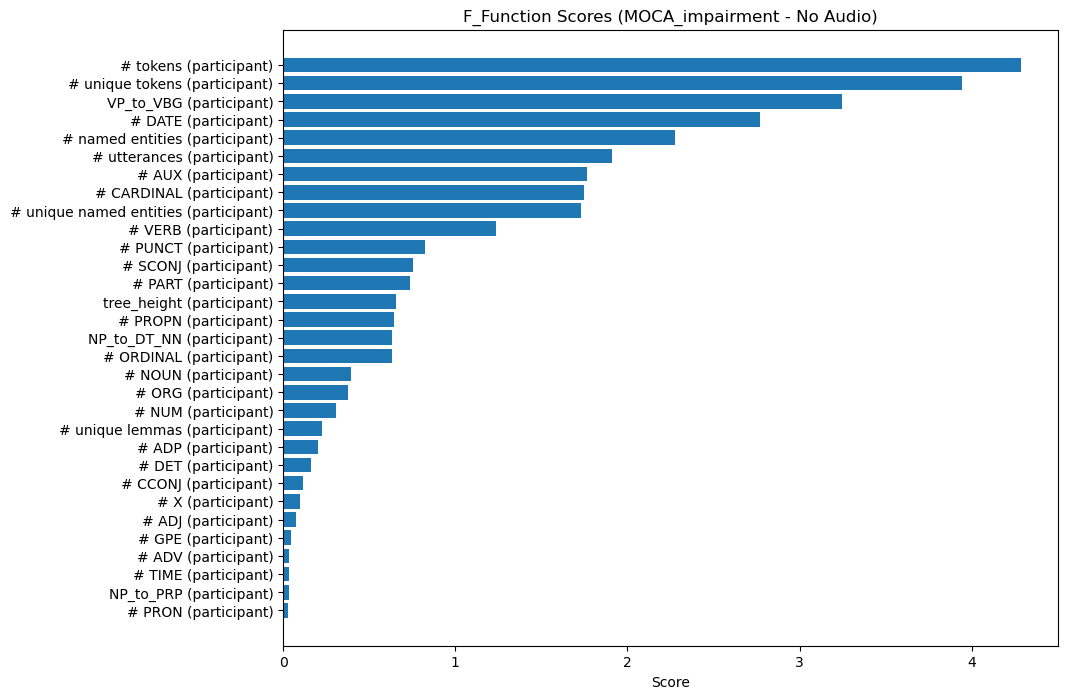

# tokens (participant), # unique tokens (participant), VP_to_VBG (participant), # DATE (participant), # named entities (participant),
# utterances (participant), # AUX (participant), # CARDINAL (participant), # unique named entities (participant), # VERB (participant),
# PUNCT (participant), # SCONJ (participant), # PART (participant), tree_height (participant), # PROPN (participant),
NP_to_DT_NN (participant), # ORDINAL (participant), # NOUN (participant), # ORG (participant), # NUM (participant),
# unique lemmas (participant), # ADP (participant), # DET (participant), # CCONJ (participant), # X (participant),
# ADJ (participant), # GPE (participant), # ADV (participant), # TIME (participant), NP_to_PRP (participant),
# PRON (participant)


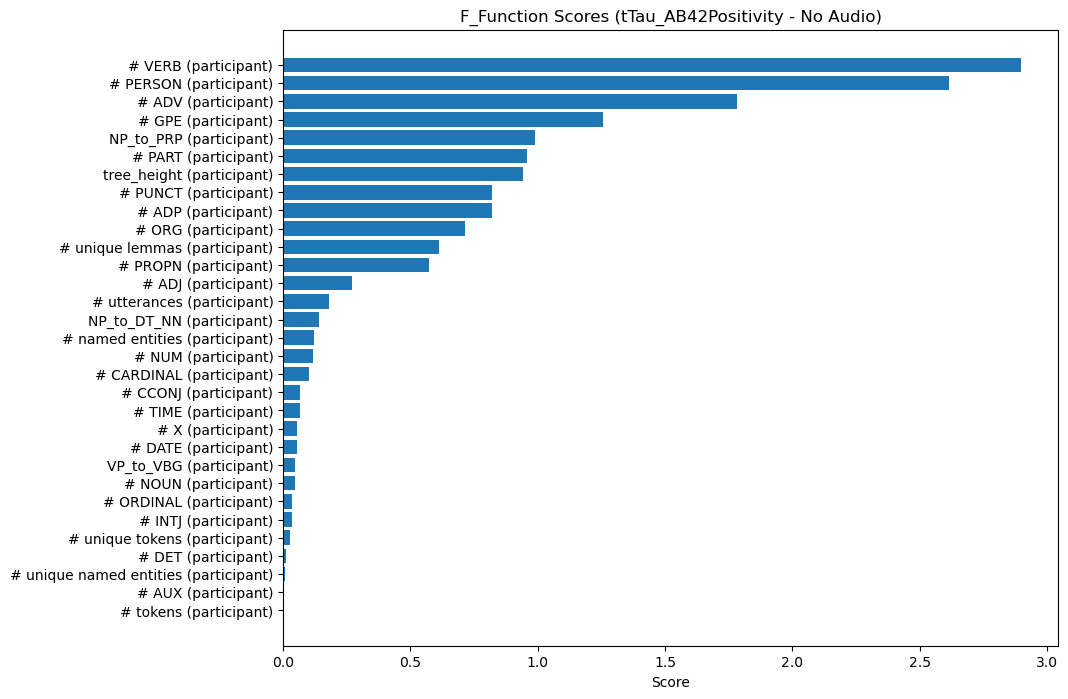

# VERB (participant), # PERSON (participant), # ADV (participant), # GPE (participant), NP_to_PRP (participant),
# PART (participant), tree_height (participant), # PUNCT (participant), # ADP (participant), # ORG (participant),
# unique lemmas (participant), # PROPN (participant), # ADJ (participant), # utterances (participant), NP_to_DT_NN (participant),
# named entities (participant), # NUM (participant), # CARDINAL (participant), # CCONJ (participant), # TIME (participant),
# X (participant), # DATE (participant), VP_to_VBG (participant), # NOUN (participant), # ORDINAL (participant),
# INTJ (participant), # unique tokens (participant), # DET (participant), # unique named entities (participant), # AUX (participant),
# tokens (participant)


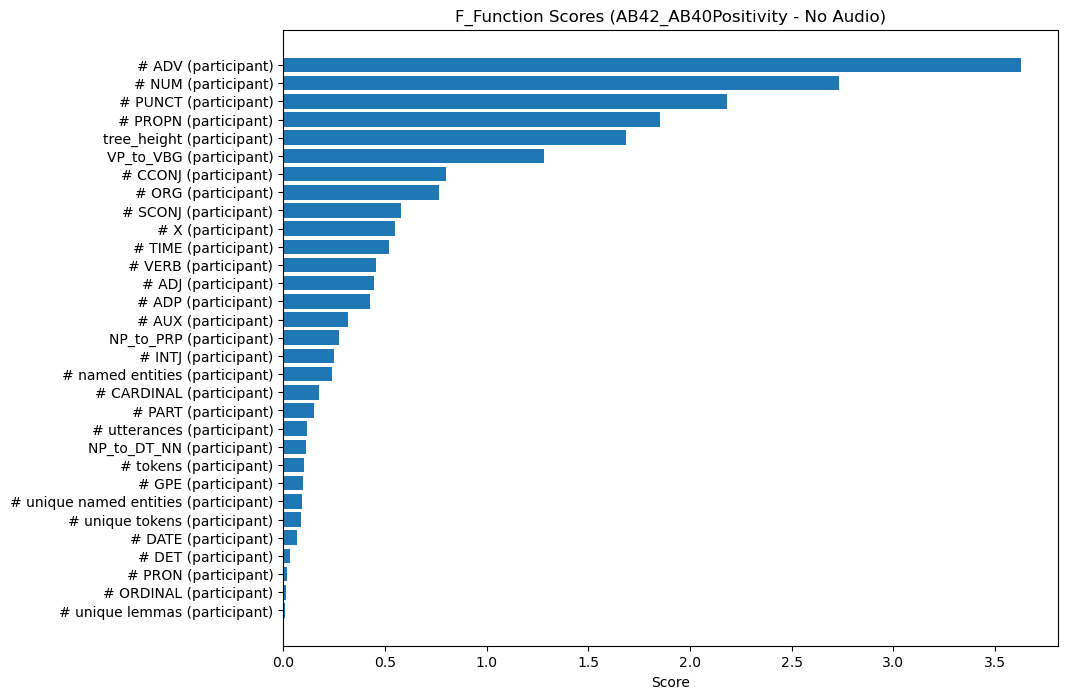

# ADV (participant), # NUM (participant), # PUNCT (participant), # PROPN (participant), tree_height (participant),
VP_to_VBG (participant), # CCONJ (participant), # ORG (participant), # SCONJ (participant), # X (participant),
# TIME (participant), # VERB (participant), # ADJ (participant), # ADP (participant), # AUX (participant),
NP_to_PRP (participant), # INTJ (participant), # named entities (participant), # CARDINAL (participant), # PART (participant),
# utterances (participant), NP_to_DT_NN (participant), # tokens (participant), # GPE (participant), # unique named entities (participant),
# unique tokens (participant), # DATE (participant), # DET (participant), # PRON (participant), # ORDINAL (participant),
# unique lemmas (participant)


In [14]:
MOCA_F_CLASSIF_NO_AUDIO_COMPUTED_FEATURES = f_info('MOCA_impairment', audio=False)
TTAU_F_CLASSIF_NO_AUDIO_COMPUTED_FEATURES = f_info('tTau_AB42Positivity', audio=False)
AB42_F_CLASSIF_NO_AUDIO_COMPUTED_FEATURES = f_info('AB42_AB40Positivity', audio=False)

## Mutual Information

In [15]:
def m_info(to_predict, runs=1000, audio=True):
    PATH = os.path.join(DATA_FOLDER, FULL_DATASET_NAME if audio else NO_AUDIO_DATASET_NAME)
    # Load the dataset
    X_raw, y_raw = load_raw_data(PATH, to_predict)
    # Get the column names (without the label)
    cols = X_raw.columns.to_list()
    X, y = X_raw.to_numpy(), y_raw.to_numpy().ravel()

    importances = mutual_info_classif(X, y)
    feat_importances = pd.Series(importances, cols)
    feat_importances = feat_importances.nlargest(32).sort_values()
    for _ in range(runs):
        new_feat_importances = pd.Series(mutual_info_classif(X, y), cols)
        new_feat_importances = new_feat_importances.nlargest(32).sort_values()
        for col in new_feat_importances.index:
            if col not in feat_importances.index:
                feat_importances[col] = 0
            feat_importances[col] += new_feat_importances[col]
    feat_importances = feat_importances / runs
    feat_importances = feat_importances.nlargest(32).sort_values()
    feat_importances.plot(kind='barh')
    plt.title(f'Mutual Information ({to_predict} - {"Full" if audio else "No Audio"})')
    plt.show()
    print_feats(list(feat_importances.index)[::-1])
    return list(feat_importances.index[::-1])

### Full Data

In [16]:
#m_info('MOCA_impairment')
#m_info('tTau_AB42Positivity')
#m_info('AB42_AB40Positivity')
pass

### No Audio

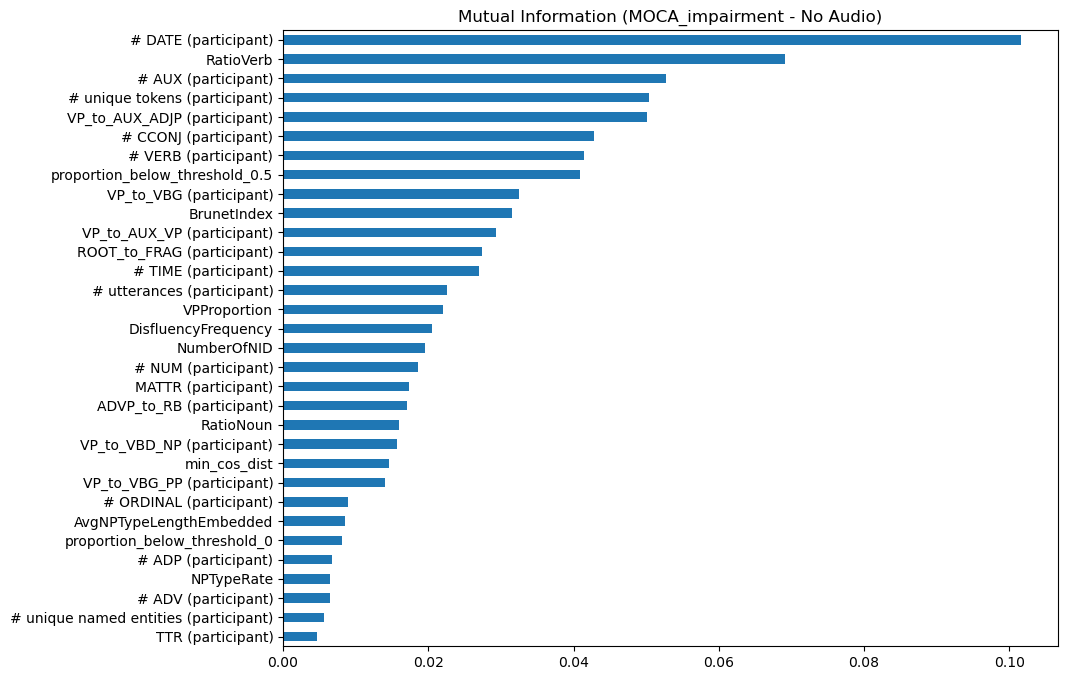

# DATE (participant), RatioVerb, # AUX (participant), # unique tokens (participant), VP_to_AUX_ADJP (participant),
# CCONJ (participant), # VERB (participant), proportion_below_threshold_0.5, VP_to_VBG (participant), BrunetIndex,
VP_to_AUX_VP (participant), ROOT_to_FRAG (participant), # TIME (participant), # utterances (participant), VPProportion,
DisfluencyFrequency, NumberOfNID, # NUM (participant), MATTR (participant), ADVP_to_RB (participant),
RatioNoun, VP_to_VBD_NP (participant), min_cos_dist, VP_to_VBG_PP (participant), # ORDINAL (participant),
AvgNPTypeLengthEmbedded, proportion_below_threshold_0, # ADP (participant), NPTypeRate, # ADV (participant),
# unique named entities (participant), TTR (participant)


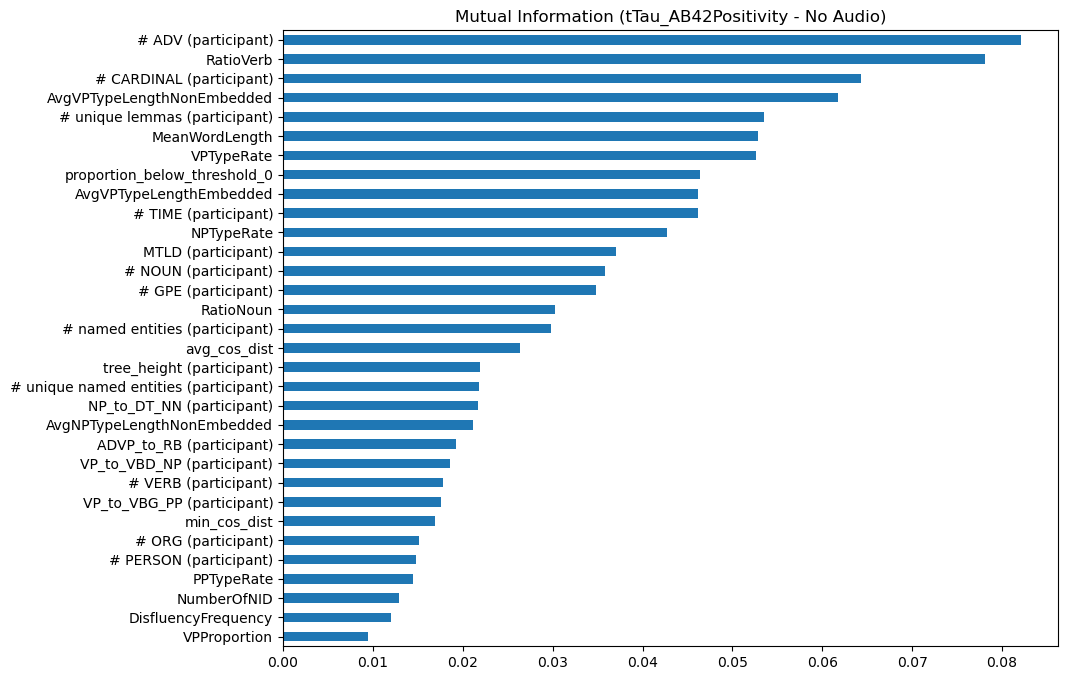

# ADV (participant), RatioVerb, # CARDINAL (participant), AvgVPTypeLengthNonEmbedded, # unique lemmas (participant),
MeanWordLength, VPTypeRate, proportion_below_threshold_0, AvgVPTypeLengthEmbedded, # TIME (participant),
NPTypeRate, MTLD (participant), # NOUN (participant), # GPE (participant), RatioNoun,
# named entities (participant), avg_cos_dist, tree_height (participant), # unique named entities (participant), NP_to_DT_NN (participant),
AvgNPTypeLengthNonEmbedded, ADVP_to_RB (participant), VP_to_VBD_NP (participant), # VERB (participant), VP_to_VBG_PP (participant),
min_cos_dist, # ORG (participant), # PERSON (participant), PPTypeRate, NumberOfNID,
DisfluencyFrequency, VPProportion


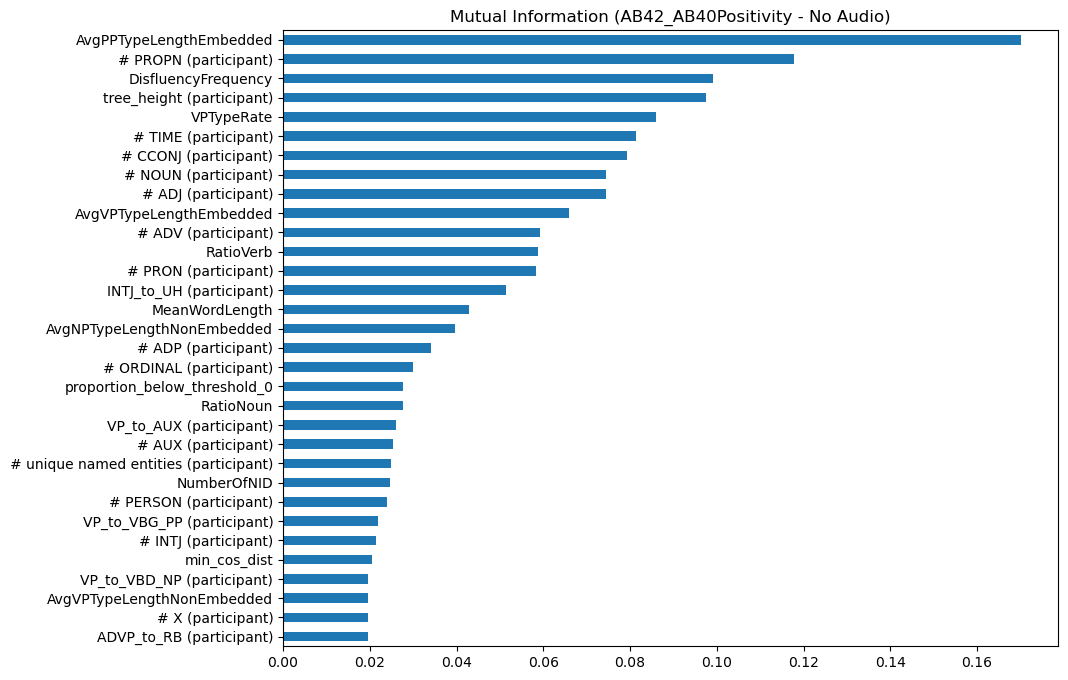

AvgPPTypeLengthEmbedded, # PROPN (participant), DisfluencyFrequency, tree_height (participant), VPTypeRate,
# TIME (participant), # CCONJ (participant), # NOUN (participant), # ADJ (participant), AvgVPTypeLengthEmbedded,
# ADV (participant), RatioVerb, # PRON (participant), INTJ_to_UH (participant), MeanWordLength,
AvgNPTypeLengthNonEmbedded, # ADP (participant), # ORDINAL (participant), proportion_below_threshold_0, RatioNoun,
VP_to_AUX (participant), # AUX (participant), # unique named entities (participant), NumberOfNID, # PERSON (participant),
VP_to_VBG_PP (participant), # INTJ (participant), min_cos_dist, VP_to_VBD_NP (participant), AvgVPTypeLengthNonEmbedded,
# X (participant), ADVP_to_RB (participant)


In [17]:
MOCA_MUTUAL_INFO_NO_AUDIO_COMPUTED_FEATURES = m_info('MOCA_impairment', audio=False)
TTAU_MUTUAL_INFO_NO_AUDIO_COMPUTED_FEATURES = m_info('tTau_AB42Positivity', audio=False)
AB42_MUTUAL_INFO_NO_AUDIO_COMPUTED_FEATURES = m_info('AB42_AB40Positivity', audio=False)

# Best features combination

After some analysis, it's clear that the best (and more easily explainable) approach is based on using the No Audio data.</br>
Thus, we will try to understand which combnation of the previously highlighted features works best for each target label.

In [18]:
PATH = os.path.join(DATA_FOLDER, NO_AUDIO_DATASET_NAME)
STEPS = [2, 4, 8, 16]

def check_top_features(X, y, feats, steps=STEPS):
    len_feats = len(feats)
    mean_accs, mean_f1s = [], []
    stdev_accs, stdev_f1s = [], []
    for _step in steps:
        step = min(_step, len_feats)
        print(f'\nChecking top {step} features')
        
        X_current = X[feats[:step]]
        accs, f1s = [], []
        for _ in tqdm(range(1000)):
            X_train, X_test, y_train, y_test = train_test_split(X_current, y, test_size=0.2, stratify=y)
            X_train, y_train = SMOTE.fit_resample(X_train, y_train)

            model = RandomForestClassifier(n_estimators=200)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            accs.append(accuracy_score(y_test, y_pred))
            f1s.append(f1_score(y_test, y_pred))

        mean_accs.append(np.mean(accs)), mean_f1s.append(np.mean(f1s))
        stdev_accs.append(np.std(accs)), stdev_f1s.append(np.std(f1s))

        if step != _step:
            break

    return (mean_accs, stdev_accs), (mean_f1s, stdev_f1s)


In [19]:
def plot_acc_and_f1(accs, f1s, feats, _steps=STEPS):
    steps = _steps[:]
    if len(feats) < _steps[-1]:
        steps = _steps[:len(accs[0])]
        steps[-1] = min(steps[-1], len(feats))
    
    x_axis = list(range(len(steps)))[:len(accs[0])]
    plt.figure(figsize=(14,6))
    plt.subplot(121)
    plt.title('Average Accuracy')
    plt.plot(x_axis, accs[0], marker='o')
    plt.xticks(ticks=x_axis, labels=steps)
    plt.subplot(122)
    plt.title('Average F1 Score')
    plt.plot(x_axis, f1s[0], marker='o')
    plt.xticks(ticks=x_axis, labels=steps)
    plt.show()

    for idx, step in enumerate(steps):
        print(f'**********   Top {step}   **********')
        print(f'Accuracy: {accs[0][idx]} +- {accs[1][idx]}')
        print(f'F1 Score: {f1s[0][idx]} +- {f1s[1][idx]}\n')

In [20]:
# Data Loading

X_moca, y_moca = load_raw_data(PATH, 'MOCA_impairment')
X_ttau, y_ttau = load_raw_data(PATH, 'tTau_AB42Positivity')
X_ab42, y_ab42 = load_raw_data(PATH, 'AB42_AB40Positivity')

### MOCA_impairment

#### ML Approach


Checking top 2 features


100%|██████████| 1000/1000 [03:26<00:00,  4.84it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:34<00:00,  4.66it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:35<00:00,  4.65it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:58<00:00,  3.35it/s]


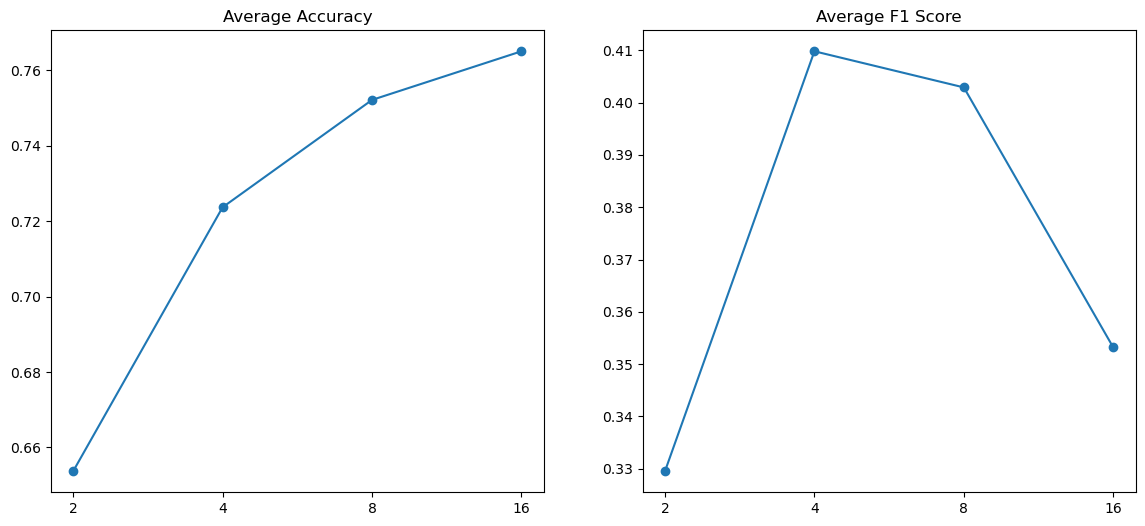

**********   Top 2   **********
Accuracy: 0.6536842105263159 +- 0.1016430122490384
F1 Score: 0.32952190211749044 +- 0.17924612615521135

**********   Top 4   **********
Accuracy: 0.7236842105263157 +- 0.09124409440913388
F1 Score: 0.40981893906746847 +- 0.19056965149584984

**********   Top 8   **********
Accuracy: 0.7521578947368421 +- 0.07895296471393023
F1 Score: 0.40290926295926294 +- 0.18428249706748515

**********   Top 16   **********
Accuracy: 0.7650526315789473 +- 0.0761377960602989
F1 Score: 0.35318657453657454 +- 0.21874876382555092



In [21]:
moca_ml_feats = MOCA_ML_NO_AUDIO_COMPUTED_FEATURES[:]

moca_ml_accs, moca_ml_f1s = check_top_features(X_moca, y_moca, moca_ml_feats)
plot_acc_and_f1(moca_ml_accs, moca_ml_f1s, moca_ml_feats)

#### Statistical Approach (F_Classif)


Checking top 2 features


100%|██████████| 1000/1000 [03:26<00:00,  4.84it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:35<00:00,  4.64it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:35<00:00,  4.64it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:58<00:00,  3.35it/s]


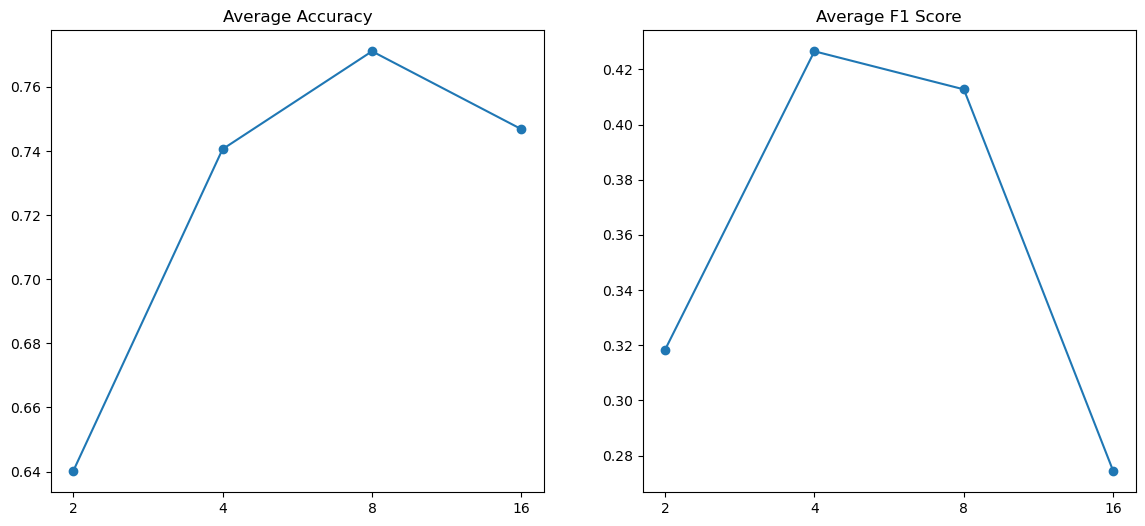

**********   Top 2   **********
Accuracy: 0.6401052631578948 +- 0.10013503348353124
F1 Score: 0.3182662225029872 +- 0.17050615257301965

**********   Top 4   **********
Accuracy: 0.740578947368421 +- 0.08509338197832834
F1 Score: 0.4265776140526141 +- 0.18156302012821435

**********   Top 8   **********
Accuracy: 0.7711052631578947 +- 0.07762397821845923
F1 Score: 0.4127682428682429 +- 0.20569914579172568

**********   Top 16   **********
Accuracy: 0.7467894736842104 +- 0.07471606456920185
F1 Score: 0.274279908979909 +- 0.21472792189955403



In [22]:
moca_f_classif_feats = MOCA_F_CLASSIF_NO_AUDIO_COMPUTED_FEATURES[:]

moca_f_classif_accs, moca_f_classif_f1s = check_top_features(X_moca, y_moca, moca_f_classif_feats)
plot_acc_and_f1(moca_f_classif_accs, moca_f_classif_f1s, moca_f_classif_feats)

#### Statistical Approach (Mutual Information)


Checking top 2 features


100%|██████████| 1000/1000 [03:28<00:00,  4.80it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:39<00:00,  4.55it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:40<00:00,  4.54it/s]



Checking top 16 features


100%|██████████| 1000/1000 [05:04<00:00,  3.28it/s]


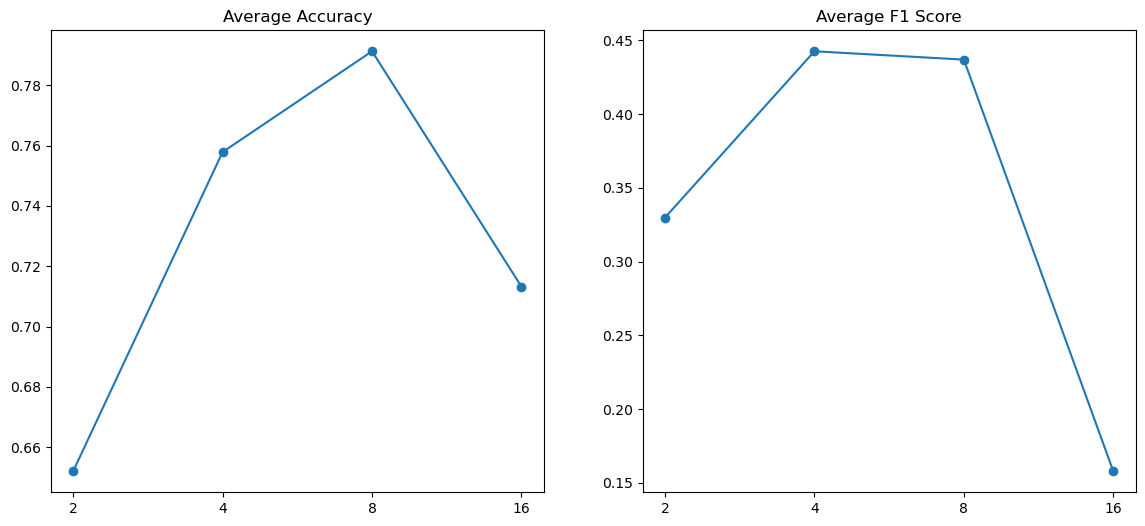

**********   Top 2   **********
Accuracy: 0.652 +- 0.10630349069040014
F1 Score: 0.32975976980535804 +- 0.17611634163271875

**********   Top 4   **********
Accuracy: 0.7578421052631578 +- 0.0835467092803717
F1 Score: 0.44251502386502384 +- 0.19209454896181472

**********   Top 8   **********
Accuracy: 0.7912631578947367 +- 0.07507787277626755
F1 Score: 0.43686665556665555 +- 0.20542211815734768

**********   Top 16   **********
Accuracy: 0.7132105263157894 +- 0.07130363073667909
F1 Score: 0.15787388167388167 +- 0.17985119401706473



In [23]:
moca_mutual_info_feats = MOCA_MUTUAL_INFO_NO_AUDIO_COMPUTED_FEATURES[:]

moca_mutual_info_accs, moca_mutual_info_f1s = check_top_features(X_moca, y_moca, moca_mutual_info_feats)
plot_acc_and_f1(moca_mutual_info_accs, moca_mutual_info_f1s, moca_mutual_info_feats)

#### Mixed Sets

In [24]:
moca_top_features = []
a, b = moca_ml_feats[:16], moca_f_classif_feats[:8]
for idx in range(max(len(a), len(b))):
    if idx < len(a):
        if a[idx] not in moca_top_features:
            moca_top_features.append(a[idx])
    if idx < len(b):
        if b[idx] not in moca_top_features:
            moca_top_features.append(b[idx])

moca_top_accs, moca_top_f1s = check_top_features(X_moca, y_moca, moca_top_features, [2,4,8,16,18])


Checking top 2 features


100%|██████████| 1000/1000 [03:31<00:00,  4.72it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:40<00:00,  4.54it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:41<00:00,  4.52it/s]



Checking top 16 features


100%|██████████| 1000/1000 [05:03<00:00,  3.30it/s]



Checking top 17 features


100%|██████████| 1000/1000 [05:03<00:00,  3.30it/s]


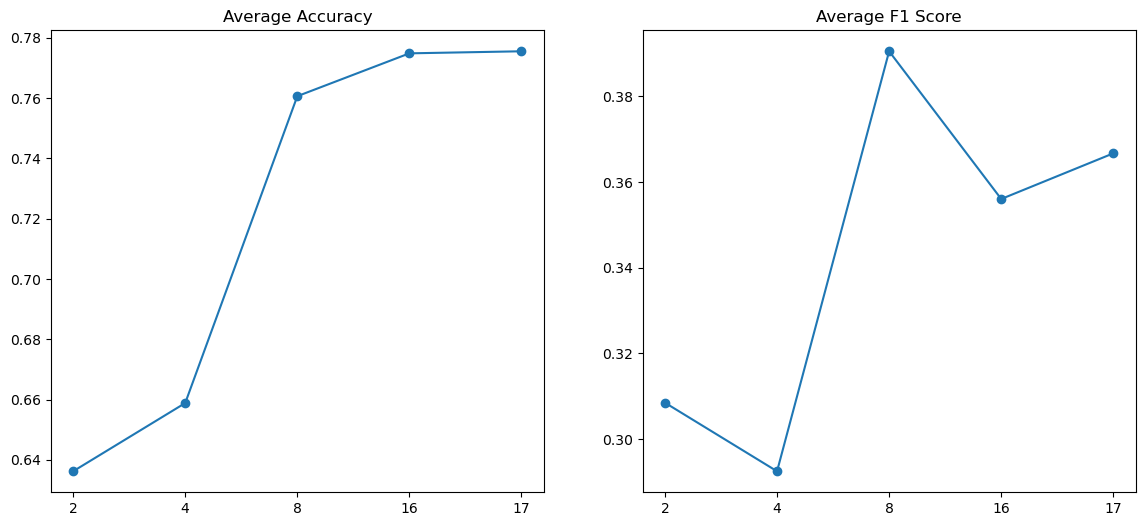

**********   Top 2   **********
Accuracy: 0.6362105263157894 +- 0.09997584195729113
F1 Score: 0.3085010807819631 +- 0.17113173818141464

**********   Top 4   **********
Accuracy: 0.6588421052631579 +- 0.09455649500654326
F1 Score: 0.29250114885114886 +- 0.1762292029399597

**********   Top 8   **********
Accuracy: 0.7606315789473683 +- 0.08064312133958222
F1 Score: 0.39051754911754916 +- 0.21331946426394724

**********   Top 16   **********
Accuracy: 0.7748421052631578 +- 0.07362245532429518
F1 Score: 0.35604527694527693 +- 0.2203046616187167

**********   Top 17   **********
Accuracy: 0.7755263157894735 +- 0.07426043487864618
F1 Score: 0.3666985514485514 +- 0.2189822045791758



In [25]:
plot_acc_and_f1(moca_top_accs, moca_top_f1s, moca_top_features, [2,4,8,16,24])

### MOCA_impairment final results

We have obtained a clear "winner" for this task, in particular the `top 8` from the `statistical approach (mutual information)`.</br>
In particular we have achieved an `accuracy of 0.7913 +- 0.0751` and an `F1 score of 0.4369 +- 0.2055`.

The best features are:
1. `# DATE (participant)`
2. `RatioVerb`
3. `# AUX (participant)`
4. `# unique tokens (participant)`
5. `VP_to_AUX_ADJP (participant)`
6. `# CCONJ (participant)`
7. `# VERB (participant)`
8. `proportion_below_threshold_0.5`

### tTau_AB42Positivity

#### ML Approach


Checking top 2 features


100%|██████████| 1000/1000 [03:58<00:00,  4.19it/s]



Checking top 4 features


100%|██████████| 1000/1000 [04:04<00:00,  4.09it/s]



Checking top 8 features


100%|██████████| 1000/1000 [04:04<00:00,  4.09it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:46<00:00,  3.49it/s]


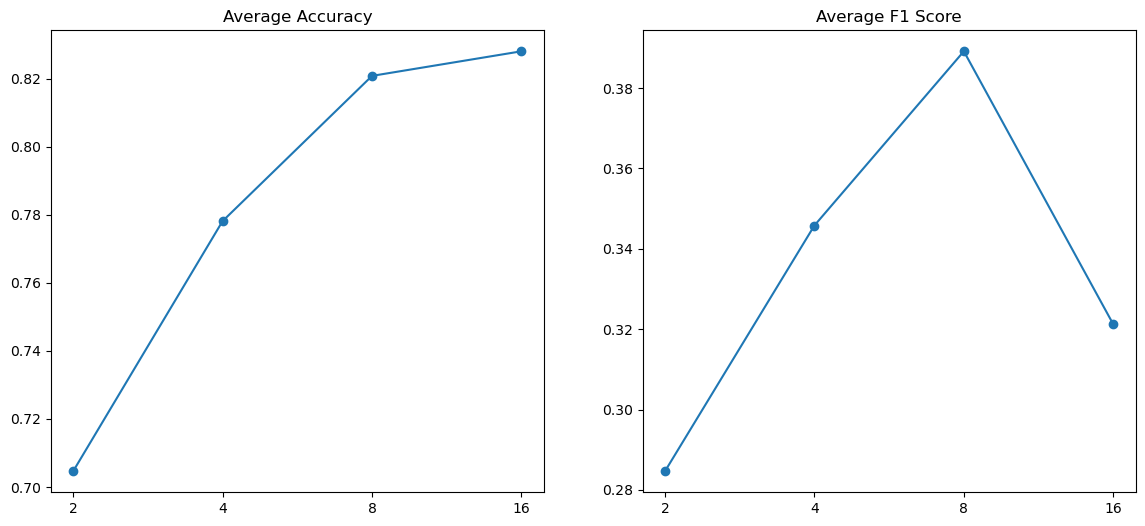

**********   Top 2   **********
Accuracy: 0.7046153846153845 +- 0.11243407009595976
F1 Score: 0.2846409090909091 +- 0.2237260410480592

**********   Top 4   **********
Accuracy: 0.7781538461538462 +- 0.09906497777966342
F1 Score: 0.34578650793650795 +- 0.26468043777157363

**********   Top 8   **********
Accuracy: 0.820846153846154 +- 0.09012676805215324
F1 Score: 0.389134126984127 +- 0.30098160304410676

**********   Top 16   **********
Accuracy: 0.8280769230769232 +- 0.08481706733460316
F1 Score: 0.3211952380952381 +- 0.31356676783606463



In [26]:
ttau_ml_feats = TTAU_ML_NO_AUDIO_COMPUTED_FEATURES[:]

ttau_ml_accs, ttau_ml_f1s = check_top_features(X_ttau, y_ttau, ttau_ml_feats)
plot_acc_and_f1(ttau_ml_accs, ttau_ml_f1s, ttau_ml_feats)

#### Statistical Approach (F_Classif)


Checking top 2 features


100%|██████████| 1000/1000 [03:58<00:00,  4.18it/s]



Checking top 4 features


100%|██████████| 1000/1000 [04:04<00:00,  4.09it/s]



Checking top 8 features


100%|██████████| 1000/1000 [04:05<00:00,  4.07it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:47<00:00,  3.48it/s]


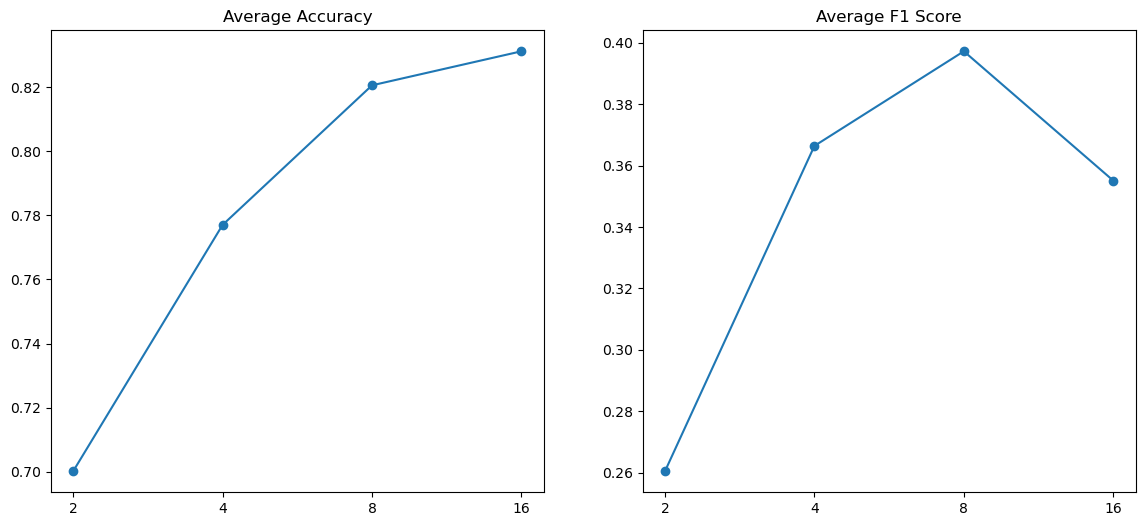

**********   Top 2   **********
Accuracy: 0.7001538461538462 +- 0.11044814574907215
F1 Score: 0.26050663780663785 +- 0.22830613157944737

**********   Top 4   **********
Accuracy: 0.7770000000000001 +- 0.09901284956357041
F1 Score: 0.3664047619047619 +- 0.26084818757072425

**********   Top 8   **********
Accuracy: 0.8205384615384617 +- 0.0927588653476945
F1 Score: 0.39721190476190477 +- 0.29695048063775753

**********   Top 16   **********
Accuracy: 0.8311538461538464 +- 0.08820950719601213
F1 Score: 0.3551047619047619 +- 0.3205563762982847



In [27]:
ttau_f_classif_feats = TTAU_F_CLASSIF_NO_AUDIO_COMPUTED_FEATURES[:]

ttau_f_classif_accs, ttau_f_classif_f1s = check_top_features(X_ttau, y_ttau, ttau_ml_feats)
plot_acc_and_f1(ttau_f_classif_accs, ttau_f_classif_f1s, ttau_f_classif_feats)

#### Statistical Approach (Mutual Information)


Checking top 2 features


100%|██████████| 1000/1000 [03:59<00:00,  4.18it/s]



Checking top 4 features


100%|██████████| 1000/1000 [04:06<00:00,  4.06it/s]



Checking top 8 features


100%|██████████| 1000/1000 [04:06<00:00,  4.05it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:51<00:00,  3.43it/s]


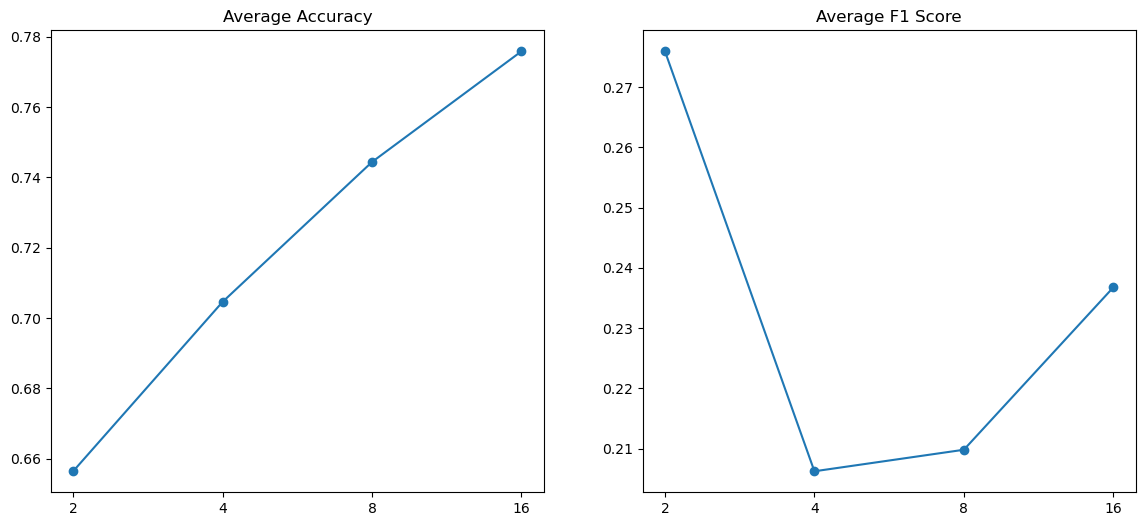

**********   Top 2   **********
Accuracy: 0.6564615384615385 +- 0.1247208480600914
F1 Score: 0.2759187312687313 +- 0.21024088807706928

**********   Top 4   **********
Accuracy: 0.7046153846153846 +- 0.11395005653625358
F1 Score: 0.20625396825396825 +- 0.23265634919416614

**********   Top 8   **********
Accuracy: 0.7443846153846153 +- 0.09834942535396748
F1 Score: 0.20982380952380952 +- 0.2497503201624871

**********   Top 16   **********
Accuracy: 0.7758461538461541 +- 0.0983474098171959
F1 Score: 0.23675476190476188 +- 0.27820119461585546



In [28]:
ttau_mutual_info_feats = TTAU_MUTUAL_INFO_NO_AUDIO_COMPUTED_FEATURES[:]

ttau_mutual_info_accs, ttau_mutual_info_f1s = check_top_features(X_ttau, y_ttau, ttau_mutual_info_feats)
plot_acc_and_f1(ttau_mutual_info_accs, ttau_mutual_info_f1s, ttau_mutual_info_feats)

In [29]:
ttau_mix_features = []
a, b = ttau_ml_feats[:8], ttau_f_classif_feats[:8]
for idx in range(max(len(a), len(b))):
    if idx < len(a):
        if a[idx] not in ttau_mix_features:
            ttau_mix_features.append(a[idx])
    if idx < len(b):
        if b[idx] not in ttau_mix_features:
            ttau_mix_features.append(b[idx])

ttau_mix_accs, ttau_mix_f1s = check_top_features(X_ttau, y_ttau, ttau_mix_features, [2,4,8,16])


Checking top 2 features


100%|██████████| 1000/1000 [04:00<00:00,  4.16it/s]



Checking top 4 features


100%|██████████| 1000/1000 [04:07<00:00,  4.05it/s]



Checking top 8 features


100%|██████████| 1000/1000 [04:07<00:00,  4.04it/s]



Checking top 15 features


100%|██████████| 1000/1000 [04:12<00:00,  3.97it/s]


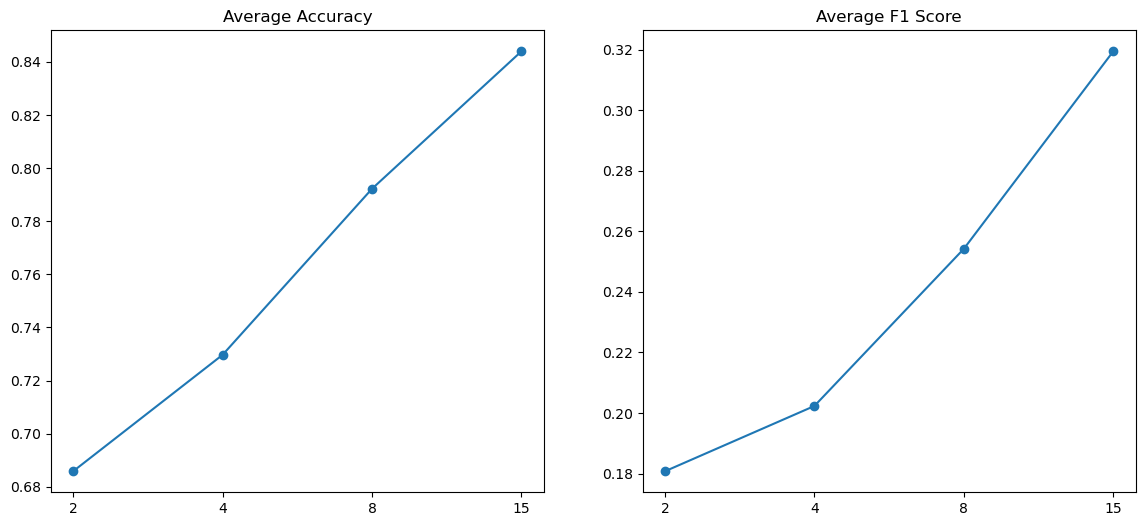

**********   Top 2   **********
Accuracy: 0.6858461538461538 +- 0.11139099004283018
F1 Score: 0.1807834054834055 +- 0.21700648951166163

**********   Top 4   **********
Accuracy: 0.7296923076923076 +- 0.10641561926554127
F1 Score: 0.20234047619047618 +- 0.2427443461456186

**********   Top 8   **********
Accuracy: 0.7922307692307693 +- 0.08789447007532661
F1 Score: 0.25422142857142854 +- 0.27790642059619924

**********   Top 15   **********
Accuracy: 0.8440000000000002 +- 0.07334832193963914
F1 Score: 0.3194190476190476 +- 0.3258321951717338



In [30]:
plot_acc_and_f1(ttau_mix_accs, ttau_mix_f1s, ttau_mix_features)

### tTau_AB42Positivity final results

For tTau we see that our possible best case scenario is obtained using the `top 8 features` from the `ML approach`.</br>
In particular we have achieved an `accuracy of 0.8208 +- 0.0901` and an `F1 score of 0.3891 +- 0.3009`.

The top features are:
1. `MATTR (participant)`
2. `VP_to_AUX_VP (participant)`
3. `# TIME (participant)`
4. `RatioNoun`
5. `RatioVerb`
6. `tree_height (participant)`
7. `BrunetIndex`
8. `AvgNPTypeLengthNonEmbedded`

### AB42_AB40Positivity

#### ML Approach


Checking top 2 features


100%|██████████| 1000/1000 [03:26<00:00,  4.83it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:29<00:00,  4.76it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:29<00:00,  4.77it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:50<00:00,  3.45it/s]


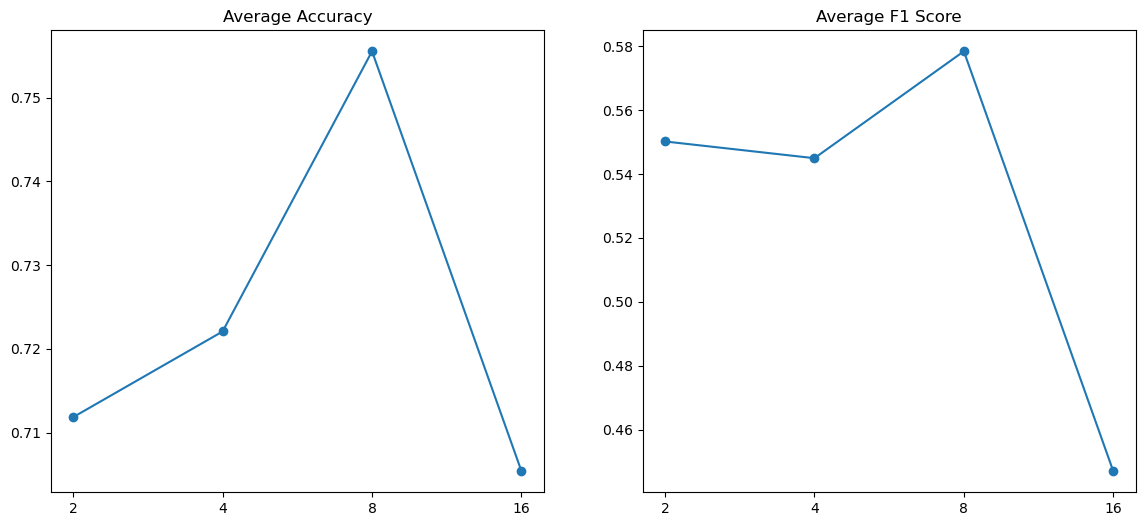

**********   Top 2   **********
Accuracy: 0.7118461538461539 +- 0.11351000268724855
F1 Score: 0.550187418137418 +- 0.18087339094011062

**********   Top 4   **********
Accuracy: 0.7220769230769231 +- 0.11118594159994984
F1 Score: 0.5449492729492729 +- 0.18869931380690796

**********   Top 8   **********
Accuracy: 0.7555384615384615 +- 0.11316626507177772
F1 Score: 0.5784070929070929 +- 0.20507451471769725

**********   Top 16   **********
Accuracy: 0.7053846153846155 +- 0.11166041078770088
F1 Score: 0.44697478632478627 +- 0.2291599644682914



In [31]:
ab42_ml_feats = AB42_ML_NO_AUDIO_COMPUTED_FEATURES[:]


ab42_ml_accs, ab42_ml_f1s = check_top_features(X_ab42, y_ab42, ab42_ml_feats)
plot_acc_and_f1(ab42_ml_accs, ab42_ml_f1s, ab42_ml_feats)

#### Statistical Approach (F_Classif)


Checking top 2 features


100%|██████████| 1000/1000 [03:29<00:00,  4.78it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:36<00:00,  4.61it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:33<00:00,  4.69it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:49<00:00,  3.45it/s]


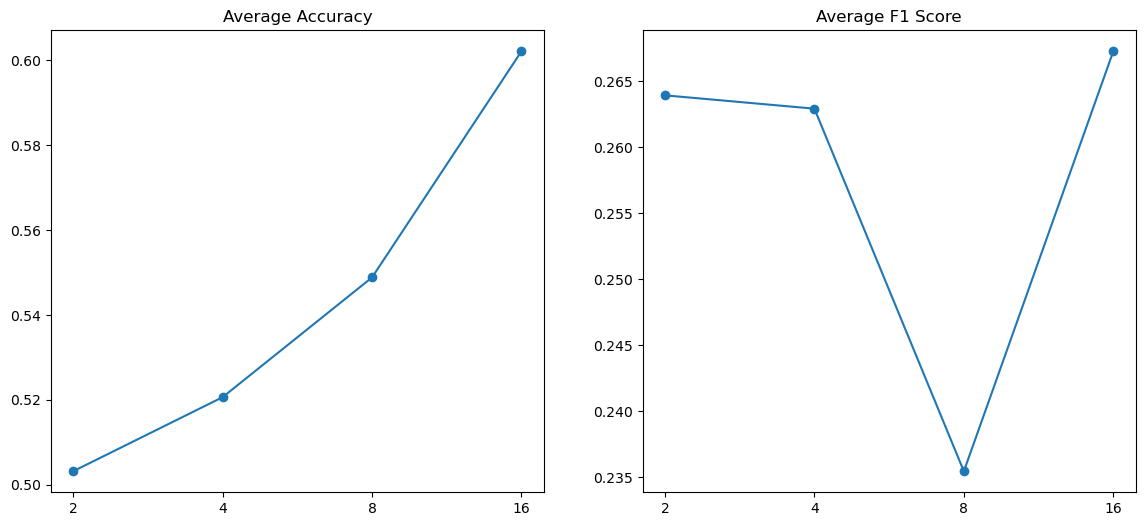

**********   Top 2   **********
Accuracy: 0.5031538461538462 +- 0.1168197671122729
F1 Score: 0.2639485902985903 +- 0.16737768453762802

**********   Top 4   **********
Accuracy: 0.5206153846153846 +- 0.11727114184682937
F1 Score: 0.2629382228882229 +- 0.18302994432041225

**********   Top 8   **********
Accuracy: 0.5488461538461538 +- 0.12561741013016728
F1 Score: 0.23546532911532914 +- 0.19191548736873096

**********   Top 16   **********
Accuracy: 0.6021538461538462 +- 0.1144168647311717
F1 Score: 0.2672868409368409 +- 0.20437657381367746



In [32]:
ab42_f_classif_feats = AB42_F_CLASSIF_NO_AUDIO_COMPUTED_FEATURES[:]


ab42_f_classif_accs, ab42_f_classif_f1s = check_top_features(X_ab42, y_ab42, ab42_f_classif_feats)
plot_acc_and_f1(ab42_f_classif_accs, ab42_f_classif_f1s, ab42_f_classif_feats)

#### Statistical Approach (Mutual Information)


Checking top 2 features


100%|██████████| 1000/1000 [03:28<00:00,  4.80it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:34<00:00,  4.66it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:33<00:00,  4.69it/s]



Checking top 16 features


100%|██████████| 1000/1000 [04:46<00:00,  3.49it/s]


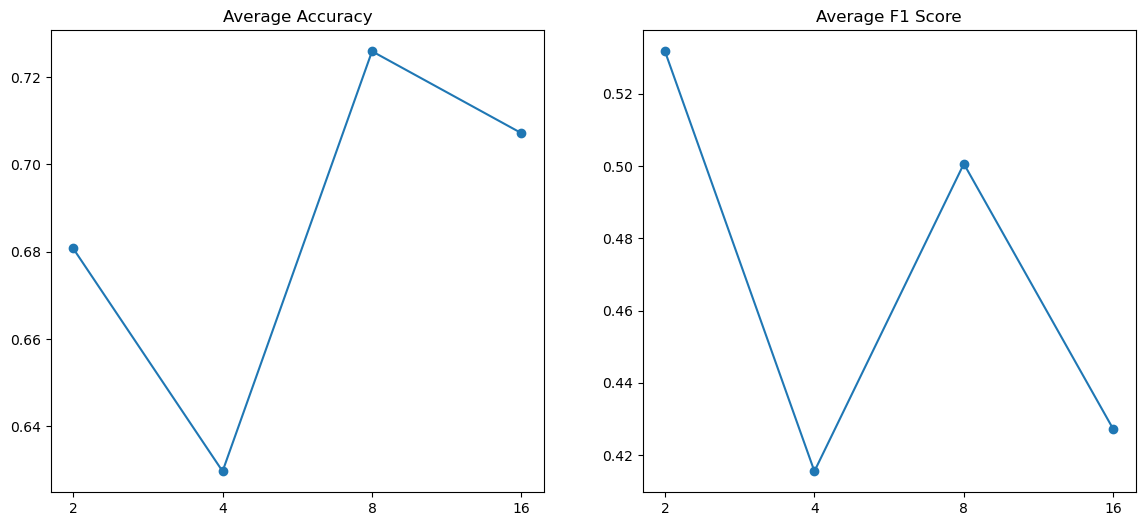

**********   Top 2   **********
Accuracy: 0.6807692307692307 +- 0.11598561428855515
F1 Score: 0.5318086746586745 +- 0.1682279259106098

**********   Top 4   **********
Accuracy: 0.6296923076923077 +- 0.12582047885542436
F1 Score: 0.4155033966033966 +- 0.20062729374231913

**********   Top 8   **********
Accuracy: 0.7259230769230769 +- 0.10884088054635772
F1 Score: 0.5006468531468531 +- 0.2110759673649417

**********   Top 16   **********
Accuracy: 0.7071538461538462 +- 0.10427975005814577
F1 Score: 0.42715086580086575 +- 0.22584519068291467



In [33]:
ab42_mutual_info_feats = AB42_MUTUAL_INFO_NO_AUDIO_COMPUTED_FEATURES[:]

ab42_mutual_info_accs, ab42_mutual_info_f1s = check_top_features(X_ab42, y_ab42, ab42_mutual_info_feats)
plot_acc_and_f1(ab42_mutual_info_accs, ab42_mutual_info_f1s, ab42_mutual_info_feats)

#### Mixed Sets

In [34]:
ab42_mixed_features = []
a, b = ab42_ml_feats[:8], ab42_mutual_info_feats[:8]
for idx in range(max(len(a), len(b))):
    if idx < len(a):
        if a[idx] not in ab42_mixed_features:
            ab42_mixed_features.append(a[idx])
    if idx < len(b):
        if b[idx] not in ab42_mixed_features:
            ab42_mixed_features.append(b[idx])

In [35]:
ab42_top_accs, ab42_top_f1s = check_top_features(X_ab42, y_ab42, ab42_mixed_features)


Checking top 2 features


100%|██████████| 1000/1000 [03:25<00:00,  4.87it/s]



Checking top 4 features


100%|██████████| 1000/1000 [03:30<00:00,  4.74it/s]



Checking top 8 features


100%|██████████| 1000/1000 [03:31<00:00,  4.72it/s]



Checking top 12 features


100%|██████████| 1000/1000 [03:37<00:00,  4.60it/s]


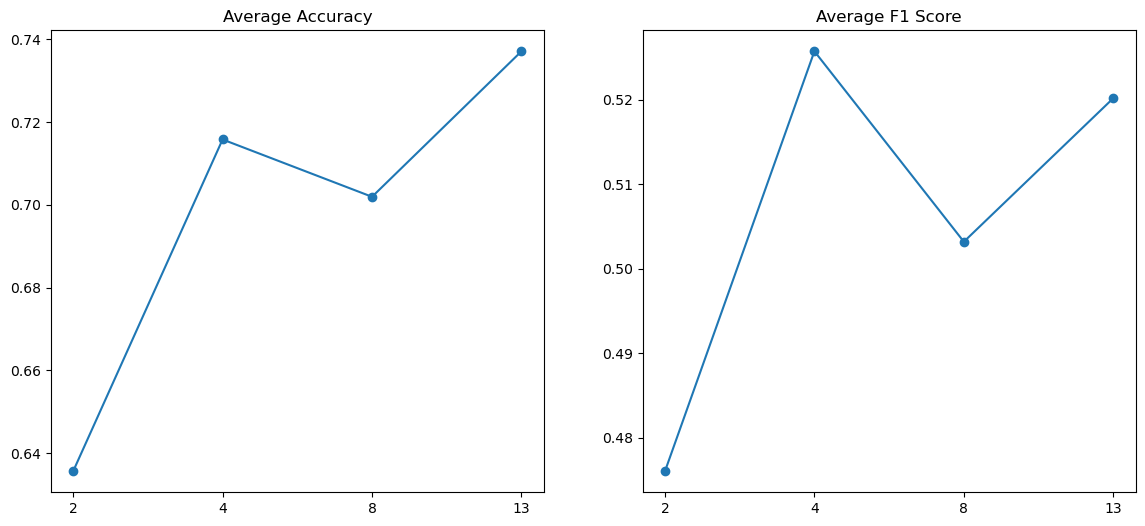

**********   Top 2   **********
Accuracy: 0.6356153846153847 +- 0.11685805378204708
F1 Score: 0.47604462204462206 +- 0.16430641198152626

**********   Top 4   **********
Accuracy: 0.7157692307692308 +- 0.10303027072851229
F1 Score: 0.52573334998335 +- 0.18558202064410437

**********   Top 8   **********
Accuracy: 0.7019230769230769 +- 0.10898604763859299
F1 Score: 0.5032006271506271 +- 0.19253326432080642

**********   Top 13   **********
Accuracy: 0.7370769230769231 +- 0.10778227011656089
F1 Score: 0.5201815406815405 +- 0.20997047550784795



In [36]:
plot_acc_and_f1(ab42_top_accs, ab42_top_f1s, ab42_mixed_features)

### AB42_AB40Positivity final results

In the end, the `top 8 ML features` achieve the top accuracy and F1 score without any other method even coming close.</br>
In particular we achieved an `accuracy of 0.7555 +- 0.1132` and an `F1 score of 0.5784 +- 0.2051`.

The features are:
1. `# TIME (participant)`
2. `RatioVerb`
3. `VP_to_AUX_VP (participant)`
4. `RatioNoun`
5. `MATTR (participant)`
6. `# NUM (participant)`
7. `# PROPN (participant)`
8. `VPTypeRate`

# Explainability

Our analysis yielded good results, but in order to strengthen our confidence in our work we need to explain our results.</br>
In particular, we are going to use the SHAP values in order to understand how the top features influence our predictions, and we'll compute the correlation between different feature groups and the target labels.

In [67]:
def load_exp(selected_feats, target, typ=int):
    # Load the entire csv file
    data = pd.read_csv('data/no_audio_corrected.csv')

    # Join labels and data so that truth values are aligned with original data
    lbls = LABELS[['id', target]]
    temp = data.merge(lbls, on='id', how='left')
    temp = temp.dropna()
    # Extract only the ground truths
    labels = temp[['id', target]].set_index('id').astype(typ)
    data = temp.drop(target, axis=1)
    data = data.set_index('id')
    # Keep just the selected features
    data = data[selected_feats]
    data = pd.DataFrame(StandardScaler().fit_transform(data), columns=data.columns, index=data.index)
    data.columns = list(map(lambda x: x.replace(' (participant)', ''), data.columns.to_list()))
    data[target] = labels
    return data.reset_index()

In [66]:
import seaborn as sns

MOCA_EXP_FEATS = [
    '# DATE (participant)', 'RatioVerb', '# AUX (participant)', '# unique tokens (participant)',
    'VP_to_AUX_ADJP (participant)', '# CCONJ (participant)', '# VERB (participant)', 'proportion_below_threshold_0.5'
 ]
TTAU_EXP_FEATS = [
    'MATTR (participant)', 'VP_to_AUX_VP (participant)', '# TIME (participant)', 'RatioNoun',
    'RatioVerb', 'tree_height (participant)', 'BrunetIndex', 'AvgNPTypeLengthNonEmbedded'
]
AB42_EXP_FEATS = [
    '# TIME (participant)', 'RatioVerb', 'VP_to_AUX_VP (participant)', 'RatioNoun',
    'MATTR (participant)', '# NUM (participant)', '# PROPN (participant)', 'VPTypeRate'
]

TARGETS = ['MOCA_impairment', 'tTau_AB42Positivity', 'AB42_AB40Positivity']

## Variable Correlation

In [128]:
from scipy.stats.stats import pearsonr, spearmanr

def get_correlation(targets, corr_func, typ=int, special=None, filt= None, encoding=None):
    series, annots = [], []
    for idx, (feats, target) in enumerate(zip([MOCA_EXP_FEATS, TTAU_EXP_FEATS, AB42_EXP_FEATS], targets)):
        corr_df = load_exp(feats, target, typ).drop('id', axis=1)
        # If any filter is present, use it before everything
        if filt:
            corr_df = filt(corr_df)
        corr_target = corr_df[target]
        corr_df = corr_df.drop(target, axis=1)
        # Encode target variable if needed
        if encoding:
            corr_target = corr_target.apply(encoding)

        corr_coeffs, p_vals = [], []
        for col in corr_df.columns:
            corr = corr_func(corr_df[col], corr_target)
            corr_coeffs.append(round(corr[0], 2))
            p_vals.append(round(corr[1], 2))

        fixed = corr_df.columns.to_list()
        for _idx in range(len(fixed)):
            if fixed[_idx] == 'AvgVPTypeLengthEmbedded':
                fixed[_idx] = 'AvgVPType\nLengthEmbedded'
            if fixed[_idx] == 'AvgNPTypeLengthNonEmbedded':
                fixed[_idx] = 'AvgNPType\nLengthNon\nEmbedded'
            if fixed[_idx] == 'proportion_below_threshold_0.5':
                fixed[_idx] = 'proportion_below\nthreshold_0.5'
        corr_df.columns = fixed

        zipped = list(zip(corr_coeffs, p_vals, corr_df.columns.to_list()))
        corr_coeffs, p_vals, indx = zip(*sorted(zipped, key=lambda x: x[0], reverse=True))
        series.append(pd.DataFrame(corr_coeffs, index=indx, columns=[target if not special else special[idx]]))
        annots.append(pd.DataFrame([f'{x}\n(p-val {y})' for x, y in zip(corr_coeffs, p_vals)], index=indx, columns=[target if not special else special[idx]]))
    return series, annots

In [125]:
def plot_correlation(series, annots, title, order=[0,1,2]):
    fig, axs = plt.subplots(ncols=3, figsize=(12,8))
    fig.suptitle(title, size=16)
    sns.heatmap(series[0], annot=annots[0], robust=True, cmap=sns.color_palette("coolwarm_r", as_cmap=True), linewidth=0.1, ax=axs[order[0]], fmt = '')
    sns.heatmap(series[1], annot=annots[1], robust=True, cmap=sns.color_palette("coolwarm_r", as_cmap=True), linewidth=0.1, ax=axs[order[1]], fmt = '')
    sns.heatmap(series[2], annot=annots[2], robust=True, cmap=sns.color_palette("coolwarm_r", as_cmap=True), linewidth=0.1, ax=axs[order[2]], fmt = '')
    plt.subplots_adjust(wspace=1.4, top=0.92)
    plt.show()

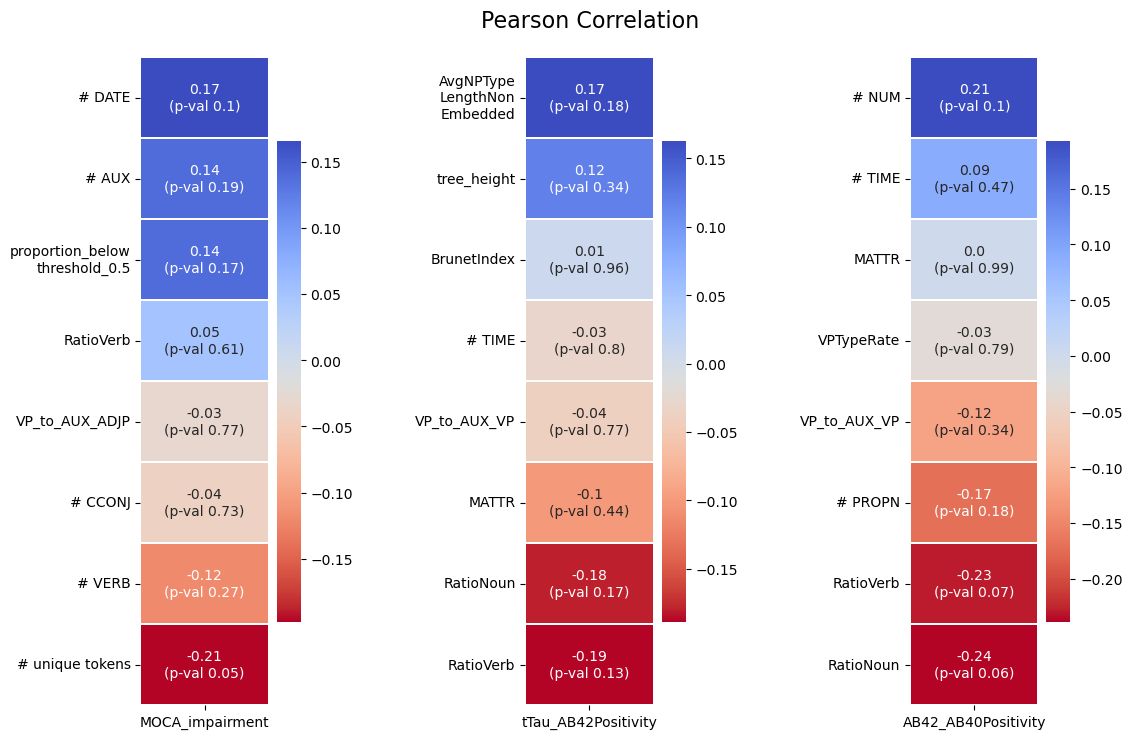

In [129]:
series, annots = get_correlation(TARGETS, pearsonr)
plot_correlation(series, annots, "Pearson Correlation")

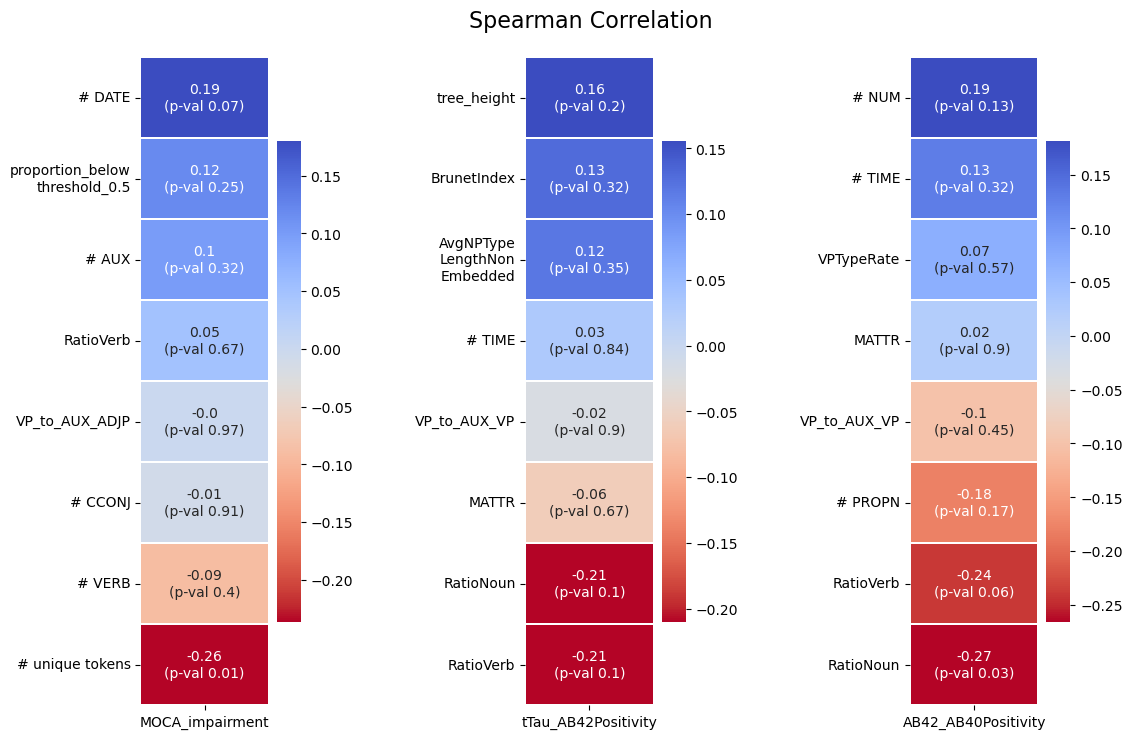

In [130]:
series, annots = get_correlation(TARGETS, spearmanr)
plot_correlation(series, annots, "Spearman Correlation")

### MOCA
Even taking into consideration both of the correlation functions, only one feature has statistical relevance: `# unique tokens`. Not exactly perfect, but the only meaningful results is also exactly what we do expect: someone healthy should probably generate more unique tokens given more complex/rich language patterns. Thus, the higher `# unique tokens` is, the lower is the probability of observing a dementia patient.

### tTau
Same story as MOCA, the only element that showed some statistical significance (only with Pearson correlation coefficients) is `BrunetIndex`. Once again, this also goes in the direction that we expected because higher BrunetIndex relates to less complex language patterns, so a high BrunetIndex correlates positively with dementia.

### AB42
Here we have 2 features that correlate negatively with Dementia: `RatioVerb` and `RatioNoun`. Also, we see that `MATTR` do not really correlates to anything (at least if we look at the Pearson correlation).

## WRT Clinical Diagnosis

In [72]:
# Filters
def filter_ad(df: pd.DataFrame):
    return df.drop(df[df['DX1'] == 'MCI'].index)

def filter_mci(df: pd.DataFrame):
    return df.drop(df[df['DX1'] == 'Prob AD'].index)

In [73]:
# Encodings
def encode_ad_mci(x):
    if x == 'Normal' or x=='Normal-PD':
        return 0
    return 1

def encode_ad(x):
    if x == 'Prob AD':
        return 1
    return 0
        
def encode_mci(x):
    if x == 'MCI':
        return 1
    return 0

### Control vs Prob AD

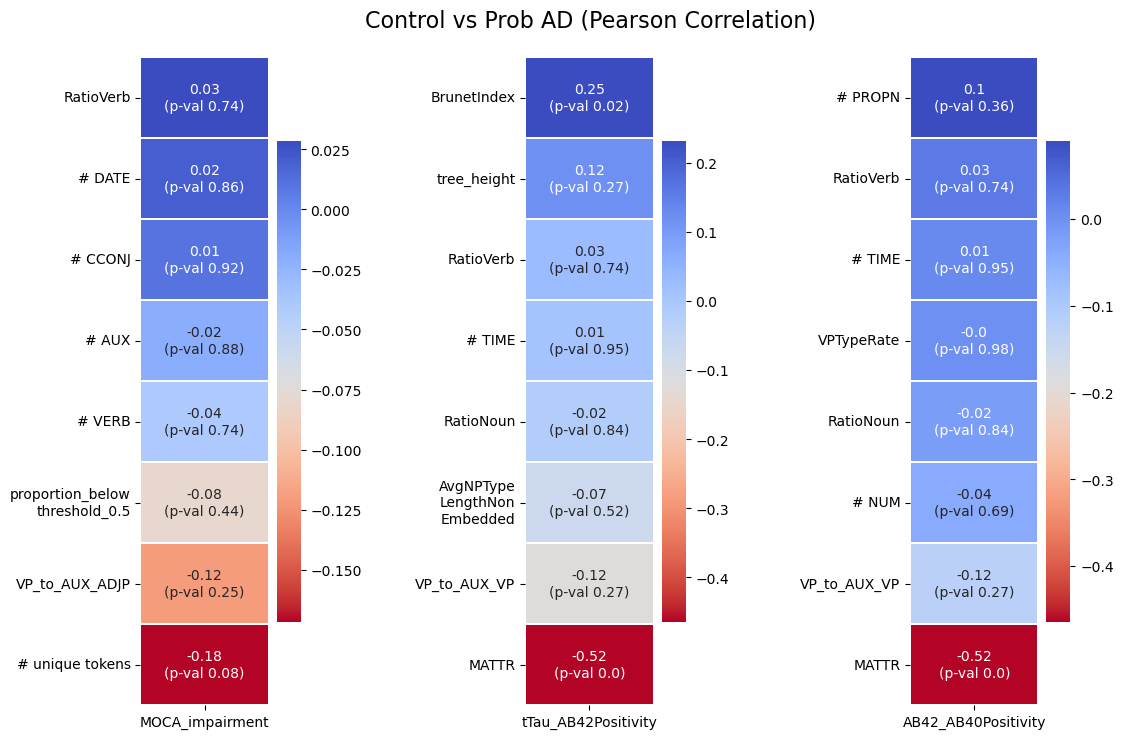

In [131]:
series, annots = get_correlation(['DX1', 'DX1', 'DX1'], pearsonr, typ=str, special=TARGETS, filt=filter_ad, encoding=encode_ad)
plot_correlation(series, annots, "Control vs Prob AD (Pearson Correlation)")

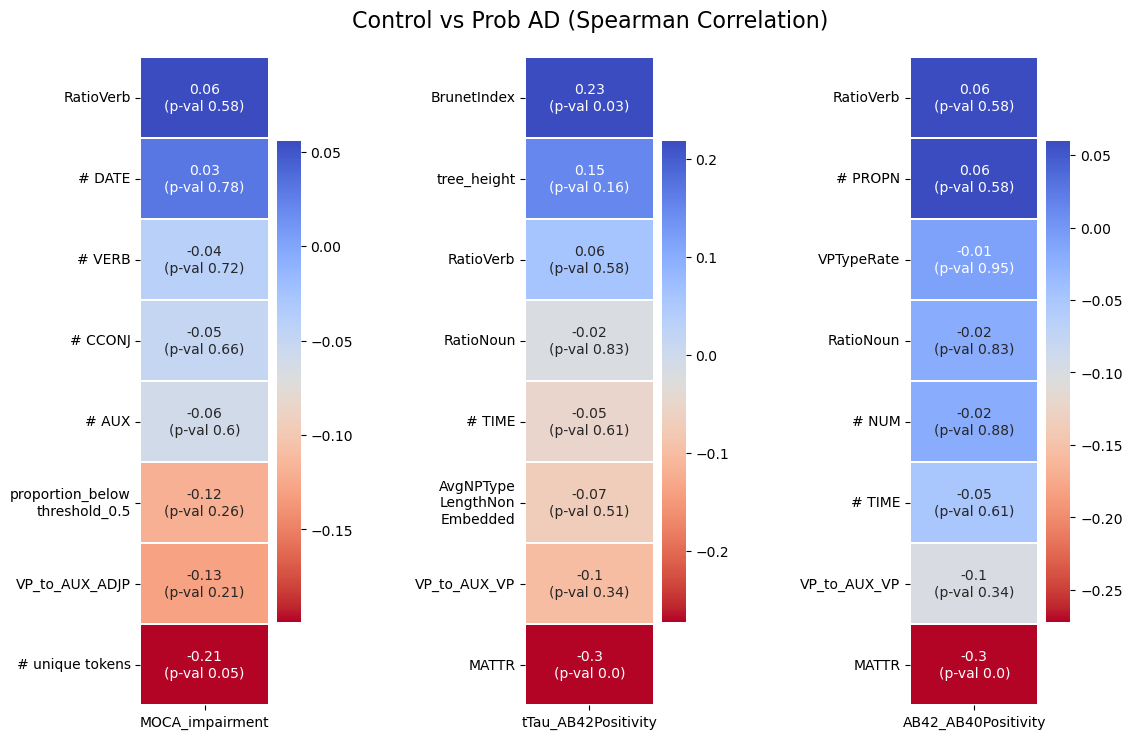

In [132]:
series, annots = get_correlation(['DX1', 'DX1', 'DX1'], spearmanr, typ=str, special=TARGETS, filt=filter_ad, encoding=encode_ad)
plot_correlation(series, annots, "Control vs Prob AD (Spearman Correlation)")

### MOCA Features
No values with statistical significance.

### tTau Features
Both `MATTR` and `BrunetIndex` show the exact correlation that we may expect (high MATTR = healthy, and high BrunetIndex = dementia).

### AB42 Features
Same as tTau for `MATTR`.

### Control vs MCI

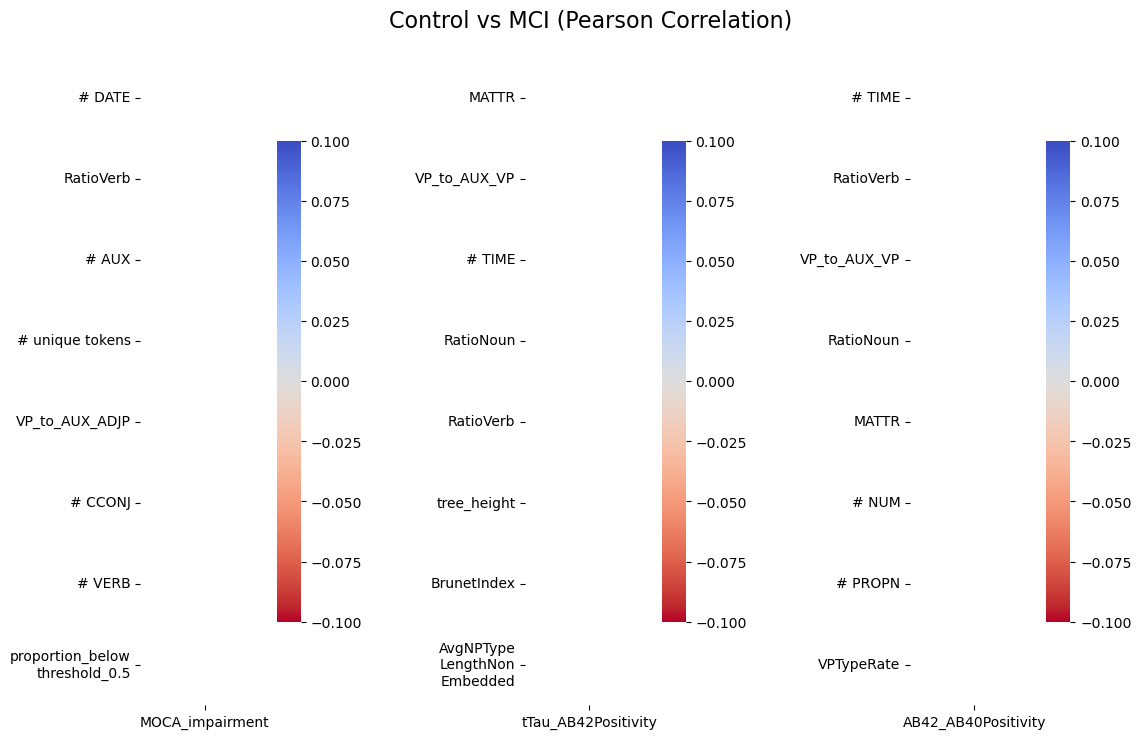

In [133]:
series, annots = get_correlation(['DX1', 'DX1', 'DX1'], pearsonr, typ=str, special=TARGETS, filt=filter_mci, encoding=encode_mci)
plot_correlation(series, annots, "Control vs MCI (Pearson Correlation)")

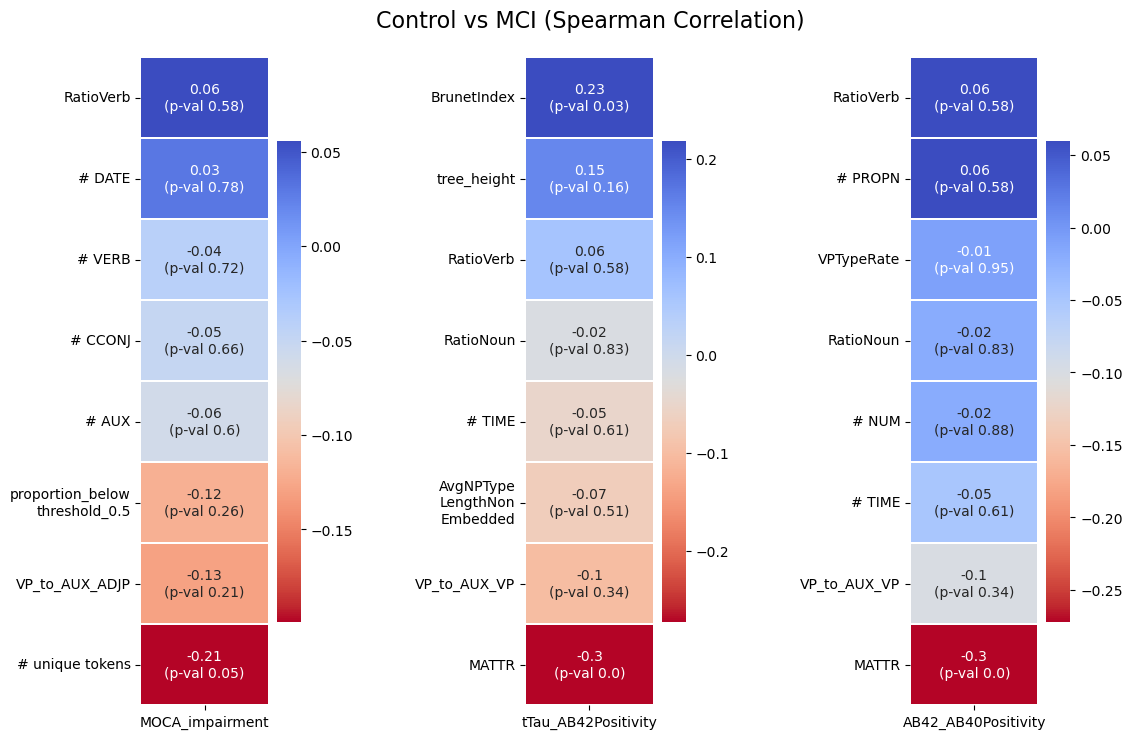

In [134]:
series, annots = get_correlation(['DX1', 'DX1', 'DX1'], spearmanr, typ=str, special=TARGETS, filt=filter_ad, encoding=encode_ad)
plot_correlation(series, annots, "Control vs MCI (Spearman Correlation)")

Interestingly, the Pearson correlation refused to produce any values for this experiment. Still unclear if this is a coding problem, or a data problem.

### MOCA Features
Expected correlation for `# unique tokens`.

### tTau Features
Expected correlation for `MATTR`.

### AB42 Features
Same as tTau for `MATTR`.

### Control vs MCI & Prob AD

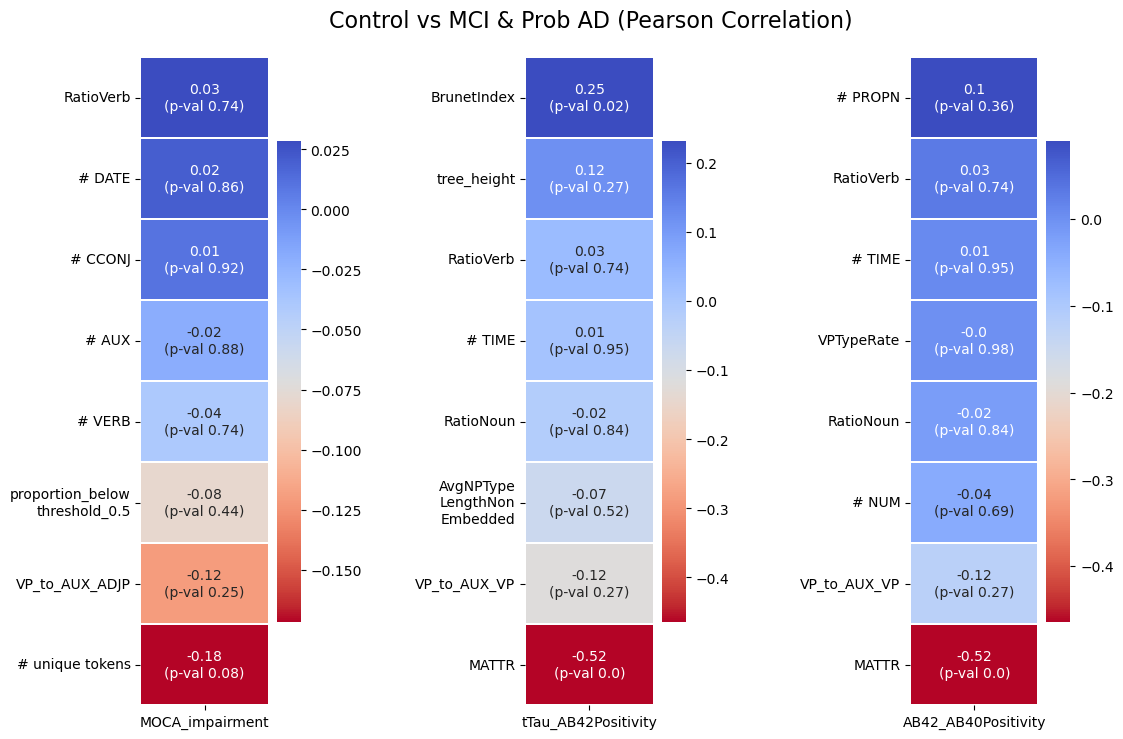

In [135]:
series, annots = get_correlation(['DX1', 'DX1', 'DX1'], pearsonr, typ=str, special=TARGETS, filt=filter_ad, encoding=encode_ad)
plot_correlation(series, annots, "Control vs MCI & Prob AD (Pearson Correlation)")

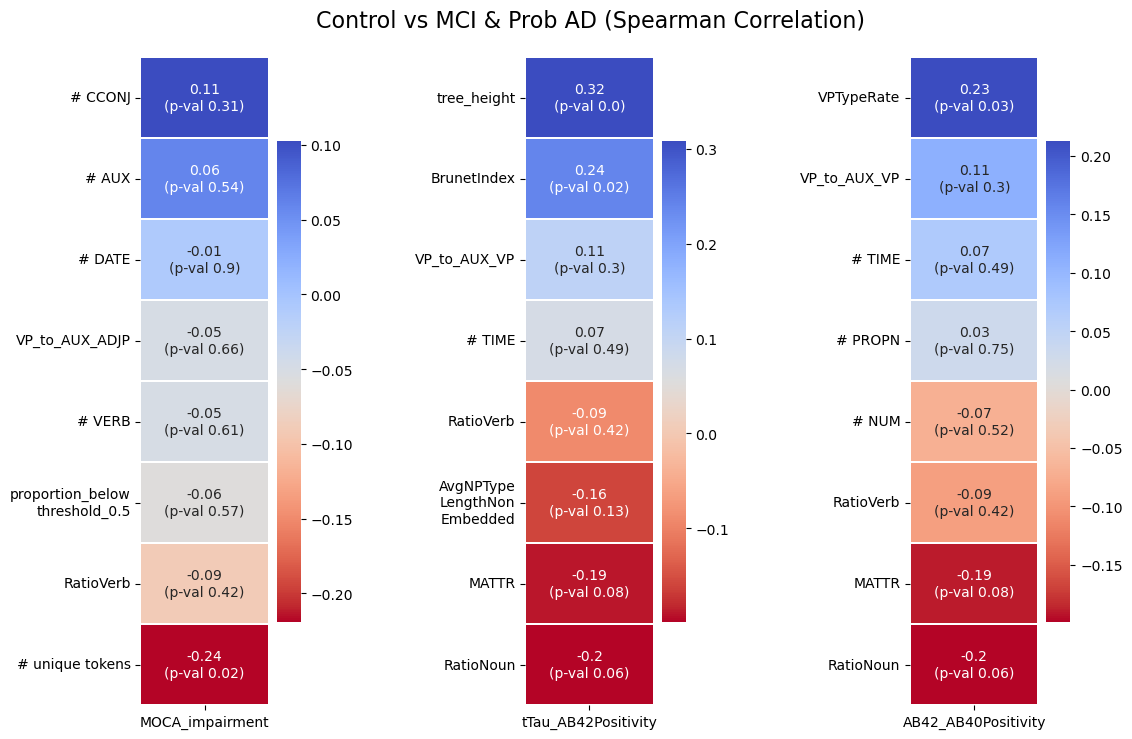

In [136]:
series, annots = get_correlation(['DX1', 'DX1', 'DX1'], spearmanr, typ=str, special=TARGETS, encoding=encode_ad_mci)
plot_correlation(series, annots, "Control vs MCI & Prob AD (Spearman Correlation)")

### MOCA Features
Expected correlation for `# unique tokens`.

### tTau Features
`tree_height` seems to be strongly correlated to dementia parient, and the possible explanation is related to the fact that dementia patient connect a lot of utterances with `AND`, and the tree may have been generated counting all these connected utterances as part of the same sentence, thus generating one enormous tree.

### AB42 Features
No significant values.

## Shap Values

In [81]:
from sklearn.model_selection import StratifiedKFold

np.random.seed(42)
CV_REPETITIONS = 1000
N_ESTIMATORS = 200

In [82]:
# Use a dict to track the SHAP values of each observation per CV repitition
# And given that we have 2 classes, we can save the SHAP values for both classes separately
def populate_dictionaries(X, cv_repetitions):
    shap_values_per_cv_0 = dict()
    shap_values_per_cv_1 = dict()

    for sample in X.index:
        # Create keys for each sample
        shap_values_per_cv_0[sample] = {}
        shap_values_per_cv_1[sample] = {}
        # Then, keys for each CV fold within each sample
        for CV_repeat in range(cv_repetitions):
            shap_values_per_cv_0[sample][CV_repeat] = {}
            shap_values_per_cv_1[sample][CV_repeat] = {}
    return shap_values_per_cv_0, shap_values_per_cv_1

In [83]:
# Split the data into folds
def get_split(X: pd.DataFrame, y: pd.DataFrame, seed:int):
    CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    idx_train, idx_test = [], []
    # Loop through each fold and append the training & test indices to the empty lists above
    for fold in CV.split(X, y):
        idx_train.append(fold[0]), idx_test.append(fold[1])
    
    return idx_train, idx_test

In [84]:
def full_cv_run(X, y, idx, idx_train, idx_test, seed, shap_values_per_cv, n_estimators=200):
    # Loop through each outer fold and extract SHAP values 
    for outer_idx_train, outer_idx_test in zip(idx_train, idx_test):
        X_train, X_test = X.iloc[outer_idx_train, :], X.iloc[outer_idx_test, :]
        y_train = y.iloc[outer_idx_train]

        model = RandomForestClassifier(n_estimators=n_estimators, random_state=seed)
        model.fit(X_train, y_train)

        # Use SHAP to explain predictions
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)

        # Extract SHAP information per fold per sample 
        for i, test_index in enumerate(outer_idx_test):
            shap_values_per_cv[0][test_index][idx] = shap_values[0][i]
            shap_values_per_cv[1][test_index][idx] = shap_values[1][i]

In [85]:
# Compute average Shap values, their Stdevs, and their min/max
def get_stats(df, shap_values_per_cv):
    average_shap_values, stds, ranges = [],[],[]
    for i in range(len(df)):
        df_per_obs = pd.DataFrame.from_dict(shap_values_per_cv[i]) # Get all SHAP values for sample number i
        # Get relevant statistics for every sample 
        average_shap_values.append(df_per_obs.mean(axis=1).values) 
        stds.append(df_per_obs.std(axis=1).values)
        ranges.append(df_per_obs.max(axis=1).values-df_per_obs.min(axis=1).values)

    return average_shap_values, stds, ranges

In [86]:
def explain(target, features, cv_repetitions, seeds):
    df = load_exp(features, target)
    X = df.drop(['id', target], axis=1)
    y = df[target]

    shap_values_per_cv_0, shap_values_per_cv_1 = populate_dictionaries(X, cv_repetitions)

    for idx in tqdm(range(cv_repetitions)):
        idx_train, idx_test = get_split(X, y, seeds[idx])
        full_cv_run(X, y, idx, idx_train, idx_test, seeds[idx], (shap_values_per_cv_0, shap_values_per_cv_1))

    
    average_shap_values_0, stds_0, ranges_0 = get_stats(df, shap_values_per_cv_0)
    average_shap_values_1, stds_1, ranges_1 = get_stats(df, shap_values_per_cv_1)

    return X, (average_shap_values_0, stds_0, ranges_0), (average_shap_values_1, stds_1, ranges_1)

In [87]:
def plot_shap_vals(X, average_values, label, cv_repetitions):
    shap.summary_plot(np.array(average_values), X, show = False)
    plt.title(f'Average SHAP values after {cv_repetitions}x cross-validation (class {label})')
    plt.show()

In [88]:
def plot_ranges(X, ranges: list, label: int):
    ranges = pd.DataFrame(ranges)
    ranges.columns = X.columns
    # Transpose dataframe to long form
    values, labels = [],[]
    for i in range(len(ranges.columns)):
        for j in range(len(ranges)):
            values.append(ranges.T[j][i])
            labels.append(ranges.columns[i])
    long_df = pd.DataFrame([values,labels]).T
    long_df.columns = ['Values', 'Features']


    title = f'Range of SHAP values per sample across all\ncross-validation repeats (class {label})'
    xlab, ylab = 'SHAP Value Variability', 'SHAP range per sample'
    sns.catplot(data = long_df, x = 'Features', y = 'Values').set(xlabel = xlab, ylabel = ylab,
                                                                                title = title)
    plt.xticks(rotation=45)
    plt.show()

### MOCA_impairment

In [89]:
MOCA_SEEDS = np.random.random_integers(100000, size=CV_REPETITIONS)
X_moca_exp, moca_class_0, moca_class_1 = explain('MOCA_impairment', MOCA_EXP_FEATS, CV_REPETITIONS, MOCA_SEEDS)

100%|██████████| 1000/1000 [15:51<00:00,  1.05it/s]


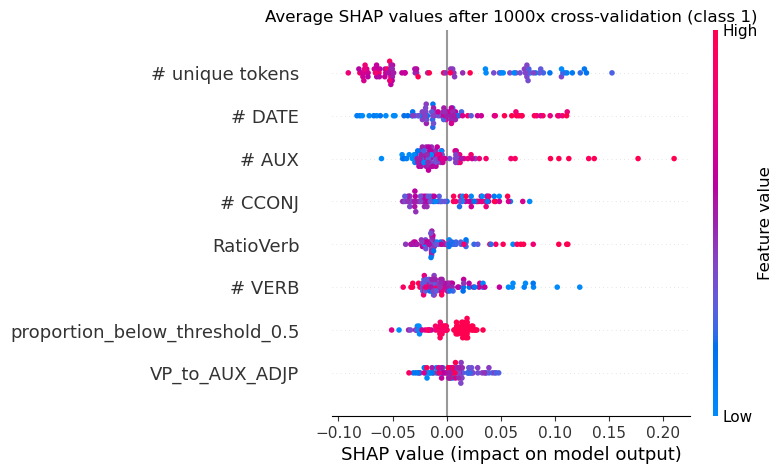

In [100]:
plot_shap_vals(X_moca_exp, moca_class_1[0], 1, CV_REPETITIONS)

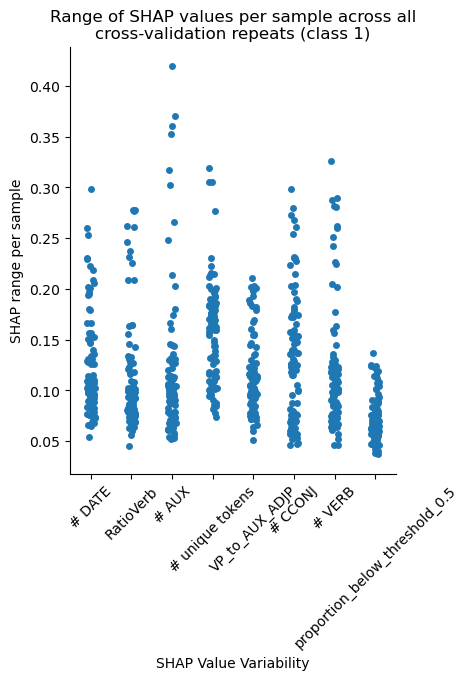

In [101]:
plot_ranges(X_moca_exp, moca_class_1[2], 1)

### tTau_AB42Positivity

In [92]:
TTAU_SEEDS = np.random.random_integers(100000, size=CV_REPETITIONS)
X_ttau_exp, ttau_class_0, ttau_class_1 = explain('tTau_AB42Positivity', TTAU_EXP_FEATS, CV_REPETITIONS, TTAU_SEEDS)

100%|██████████| 1000/1000 [15:14<00:00,  1.09it/s]


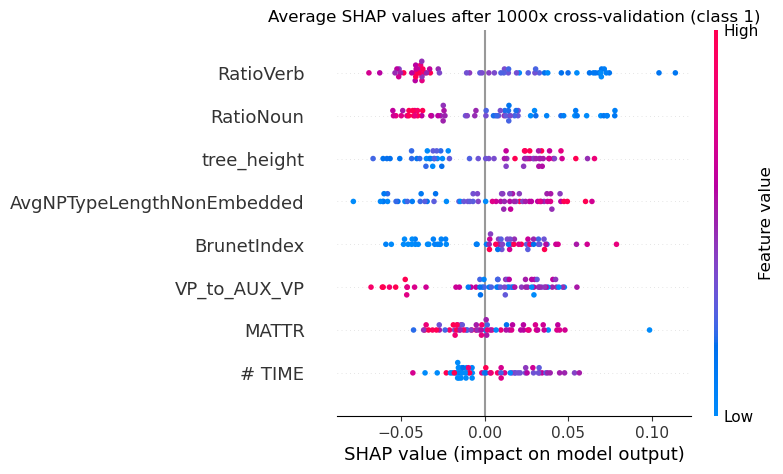

In [102]:
plot_shap_vals(X_ttau_exp, ttau_class_1[0], 1, CV_REPETITIONS)

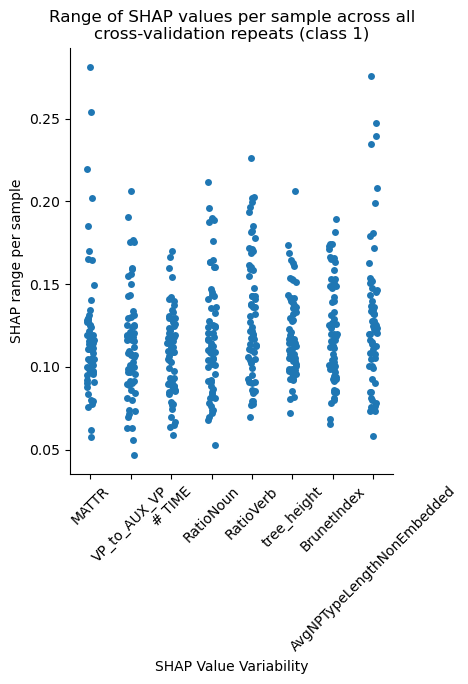

In [103]:
plot_ranges(X_ttau_exp, ttau_class_1[2], 1)

### AB42_AB40Positivity

In [95]:
AB42_SEEDS = np.random.random_integers(100000, size=CV_REPETITIONS)
X_ab42_exp, ab42_class_0, ab42_class_1 = explain('AB42_AB40Positivity', AB42_EXP_FEATS, CV_REPETITIONS, AB42_SEEDS)

100%|██████████| 1000/1000 [15:24<00:00,  1.08it/s]


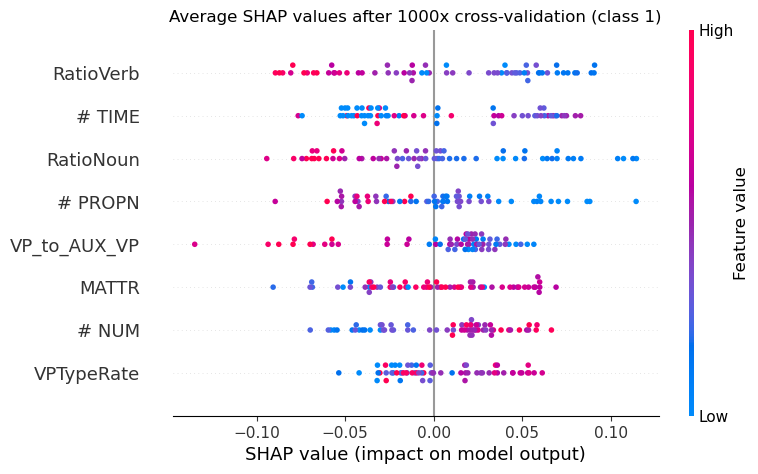

In [105]:
plot_shap_vals(X_ab42_exp, ab42_class_1[0], 1, CV_REPETITIONS)

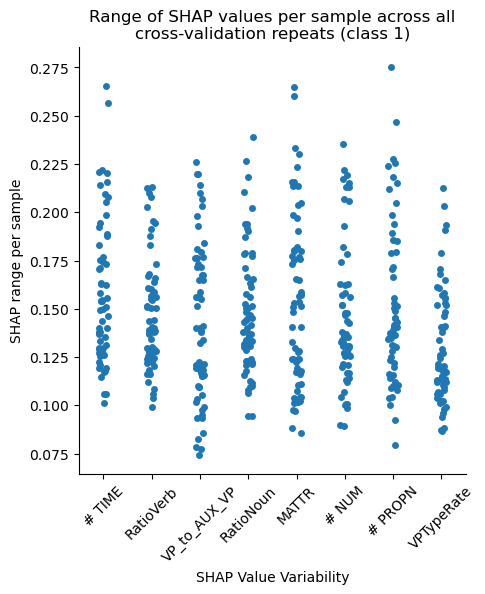

In [106]:
plot_ranges(X_ab42_exp, ab42_class_1[2], 1)